

# LSTM using Keras


## Getting started
A good [article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) about the theory of LSTM RNNs.
<br>
Intro to LSTM using Keras in a hands on [article](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/).
<br><br>
The practical article explains how to use LSTM to predict the graph of number of international airline passengers per month.
<img style="width:600px" src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/LSTM-Trained-on-Regression-Formulation-of-Passenger-Prediction-Problem-1.png">
As we can see, there is a noticable pattern in the graph, so it should be easily predictable.
<br>
A simple NN should be able to learn the function of the graph and predict it and we can see that it actually does - the blue is the actual graph, the green is the prediction of the training set and the red is the prediction of the testing set.
<br><br>
Stock prices are much more chaotic and can't be so predictable, but I just wanted to give it a try and apply the same method on the graph of the "Close" prices of the Facebook stock.
<br>

The following code is the code from the article (most of the code **is not my code**). I made some modifications to the code in order to execute on the facebook stock data and be able to get general parameters.
<br>
This following model uses an LSTM network with the following configuration:
- 1 input layer
- 1 output layer
- 2 LSTM layers (4 neurons each)
- Saving sequence state between the iterations of every epoch
- Resetting the state after every epoch

In [49]:
import logging
import math
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import hyperopt
from hyperopt import hp

In [56]:
def learn_and_predict(epochs, look_back=3):
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])

        return numpy.array(dataX), numpy.array(dataY)

    # fix random seed for reproducibility
    numpy.random.seed(7)

    # load the dataset
    dataframe = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=[4], engine='python', skipfooter=3)
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # create and fit the LSTM network
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        print("epoch {}".format(i + 1))
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    actualPlot = scaler.inverse_transform(dataset)
    
    return actualPlot, trainPredictPlot, testPredictPlot

#### Run 100 epochs with batch_size=1 (default) and a window size of 10:

In [3]:
actualPlot, trainPredictPlot, testPredictPlot = learn_and_predict(100, 10)

Instructions for updating:
Colocations handled automatically by placer.
epoch 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 15s - loss: 2.8743e-04
epoch 2
Epoch 1/1
 - 14s - loss: 0.0010
epoch 3
Epoch 1/1
 - 13s - loss: 8.7839e-04
epoch 4
Epoch 1/1
 - 15s - loss: 7.1724e-04
epoch 5
Epoch 1/1
 - 14s - loss: 5.1728e-04
epoch 6
Epoch 1/1
 - 13s - loss: 4.3035e-04
epoch 7
Epoch 1/1
 - 13s - loss: 3.4095e-04
epoch 8
Epoch 1/1
 - 14s - loss: 3.0775e-04
epoch 9
Epoch 1/1
 - 15s - loss: 2.8337e-04
epoch 10
Epoch 1/1
 - 12s - loss: 2.7183e-04
epoch 11
Epoch 1/1
 - 14s - loss: 2.6266e-04
epoch 12
Epoch 1/1
 - 16s - loss: 2.5265e-04
epoch 13
Epoch 1/1
 - 15s - loss: 2.3144e-04
epoch 14
Epoch 1/1
 - 15s - loss: 1.8603e-04
epoch 15
Epoch 1/1
 - 15s - loss: 1.3697e-04
epoch 16
Epoch 1/1
 - 14s - loss: 1.2039e-04
epoch 17
Epoch 1/1
 - 14s - loss: 1.1777e-04
epoch 18
Epoch 1/1
 - 15s - loss: 1.1525e-04
epoch 19
Epoch 1/1
 - 12s - loss: 1.1081e-04
epoch 20
Epoch 1/1
 - 13s - loss: 1.05

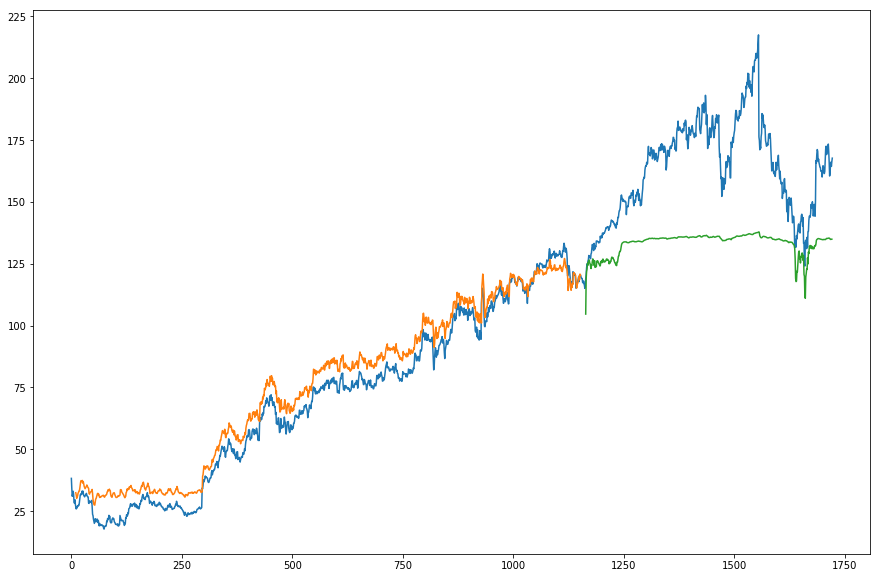

In [4]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(actualPlot)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that it takes **much** longer to train a model of RNN comparing to a simple polynomial regression.
<br>
Many epochs are needed in order to converge and minimize the loss. Each epoch goes through the entire dataset and calculates the weights of the model. It takes 12s in average for every epoch in this configuration.
<br>
I also tried running it with different configurations and got the evidence that if I increase the batch size, each epoch runs faster, but it takes much more time to converge. The loss may go up and down many times.

#### Some observations:
- The predictions on the training set are pretty good (maybe due to overfitting).
- The preidctions on the testing set on first days are more or less close to actual, but as the days pass and we are predicting more to the future, the prediction are far away from the actual values.
- LSTM RMSE - on the training set: 6.897
- LSTM RMSE - on the testing set: 34.42
- Linear Regression RMSE - 3.38

#### Intermmediate Conclusions:
- This model configuration may not be optimal. I may spend a lot of time on finding the right model configuration that will fit the best and on finding different performance/model optimization methods.
- It's useless to predict so far to the future.
- Therefore it's also probably useless to look too much time back to the past when training the model. i.e. window size shouldn't be that large.
- I need to get back to my initial training and validation method of training on last X days and predicting the following day

<font color=red>
<b>Edit - this is a misconception of how LSTM works</b>
<br>
Later in the notebook, under the "Changing Course" cell, I explain that.
</font>

#### Plan:
1. Run the same network with the previous training-validation method and try to get RMSE < 3.38
1. If I won't get the same RMSE, try to increase window size to cover the whole dataset + find ways to optimize model training time (maybe run Keras on a machine with GPU)
1. When getting to RMSE of 3.38 - change the network to include more layers (verify that the model is not overfitting).
1. Use more features (Open, Volume, etc) - check if it decreases the loss.
1. Try to edit the Forget gates of the LSTM layers in order to control the weights of past days. This way we'll be able to increase the window size and give more impact to the last days
1. Try stocks with lower volatility. Facebook stock is pretty volatile - it has a Beta value of 1.2 for the last 3Y Monthly, while Pepsi stock has a Beta value of 0.5

In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


def predict_close_lstm(df, cur_day, num_of_days, window_size=10, look_back=4, epochs=100, plot=False, plot_callback=None, loss_threshold=1e-4):
    actuals = []
    predictions = []

    # Go through all requested days and make a new training for every day
    for i in range(cur_day, cur_day + num_of_days):
        print("Training day {}/{}".format(i - cur_day, num_of_days))
        # For each day, train a new model using Close values of previous days.
        # Number of previous days is defined by "window_size"
        samples_start = i - window_size
        samples_end = i - 1

        # Important!
        # The training set will be taken from [samples_start:samples_end + 1]
        # and the last sample is for the prediction of next day
        df_cur_dataset = df[samples_start:samples_end + 2]

        actual, predicted = train_lstm(df_cur_dataset, look_back, epochs, plot=plot, plot_callback=plot_callback, loss_threshold=loss_threshold)
        actuals.append(actual)
        predictions.append(predicted)

    return actuals, predictions


def train_lstm(df, look_back, epochs, plot=False, plot_callback=None, loss_threshold=10**-4):
    print(epochs)
    # Normalize the whole dataset (this will include Xs and Ys)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df.values.astype('float32'))

    # reshape into X=t and Y=t+1
    train_x, train_y, x_inc_predict, y_inc_predict = create_lstm_dataset(dataset, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    x_inc_predict = np.reshape(x_inc_predict, (x_inc_predict.shape[0], x_inc_predict.shape[1], 1))

    # create and fit the LSTM network
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        print("epoch {}".format(i + 1))
        res = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
        if res.history["loss"][0] < loss_threshold:
            print("Loss is lower than threshold of {}. Quitting.".format(loss_threshold))
            break

    # make predictions
    train_predict = model.predict(x_inc_predict, batch_size=batch_size)
    model.reset_states()

    # invert predictions
    train_y = scaler.inverse_transform([train_y])
    train_predict = scaler.inverse_transform(train_predict)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_y[0], train_predict[:-1, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    # shift train predictions for plotting
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

    if plot_callback:
        plot_callback(scaler.inverse_transform(dataset), train_predict_plot)

    if plot:
        # plot baseline and predictions
        plt.figure(figsize=(15, 10))
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(train_predict_plot)
        plt.show()

    actual = train_y[0]
    predicted = train_predict[:-1, 0]

    return actual, predicted


def create_lstm_dataset(dataset, look_back=1):
    # Actual training set
    data_x, data_y = [], []

    # X and Y sets that include the last sample (which is not part of the training set)
    # This will be used for predicting and ploting the next day
    data_inc_predict_x, data_inc_predict_y = [], []

    def add_i_features(ds_x, ds_y, i):
        # Append to the list of timeseries, a 1 dimensional array that
        # includes values of our single feature (index 0) across current look_back range
        ds_x.append(dataset[i:(i + look_back), 0])

        # Append to the list of Ys, the y of the current look_back, which is our feature
        # of next day after our look_back range
        ds_y.append(dataset[i + look_back, 0])

    # Go through all training samples
    # For example
    # if the windows size is 10
    # 11 samples will be passed
    # samples 0-9 will be used for the training set
    # sample 10 will be used for the prediction
    for i in range(len(dataset) - look_back - 1):
        add_i_features(data_x, data_y, i)
        add_i_features(data_inc_predict_x, data_inc_predict_y, i)

    # Add the last sample for prediction purposes
    add_i_features(data_inc_predict_x, data_inc_predict_y, i + 1)

    return np.array(data_x), np.array(data_y), np.array(data_inc_predict_x), np.array(data_inc_predict_y)


In [11]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=["Close"], engine='python', skipfooter=3)

# A callback to save plot data from within the training function in order to be able to plot the data in a different cell in Jupyter.
ds1 = None
ds2 = None
def save_plot_data(original_dataset, predicted_shifted_dataset):
    global ds1
    global ds2
    ds1 = original_dataset
    ds2 = predicted_shifted_dataset
numebr_of_days = 1
first_day = int(len(df) / 2)
res_actuals, res_predicted = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=5000, plot=False, plot_callback=save_plot_data, loss_threshold=1e-4)

Training day 0/1
5000
epoch 1
Epoch 1/1
 - 2s - loss: 0.4646
epoch 2
Epoch 1/1
 - 0s - loss: 0.4373
epoch 3
Epoch 1/1
 - 0s - loss: 0.4107
epoch 4
Epoch 1/1
 - 0s - loss: 0.3849
epoch 5
Epoch 1/1
 - 0s - loss: 0.3595
epoch 6
Epoch 1/1
 - 0s - loss: 0.3341
epoch 7
Epoch 1/1
 - 0s - loss: 0.3085
epoch 8
Epoch 1/1
 - 0s - loss: 0.2822
epoch 9
Epoch 1/1
 - 0s - loss: 0.2552
epoch 10
Epoch 1/1
 - 0s - loss: 0.2274
epoch 11
Epoch 1/1
 - 0s - loss: 0.1991
epoch 12
Epoch 1/1
 - 0s - loss: 0.1705
epoch 13
Epoch 1/1
 - 0s - loss: 0.1424
epoch 14
Epoch 1/1
 - 0s - loss: 0.1155
epoch 15
Epoch 1/1
 - 0s - loss: 0.0908
epoch 16
Epoch 1/1
 - 0s - loss: 0.0693
epoch 17
Epoch 1/1
 - 0s - loss: 0.0518
epoch 18
Epoch 1/1
 - 0s - loss: 0.0385
epoch 19
Epoch 1/1
 - 0s - loss: 0.0294
epoch 20
Epoch 1/1
 - 0s - loss: 0.0238
epoch 21
Epoch 1/1
 - 0s - loss: 0.0206
epoch 22
Epoch 1/1
 - 0s - loss: 0.0191
epoch 23
Epoch 1/1
 - 0s - loss: 0.0185
epoch 24
Epoch 1/1
 - 0s - loss: 0.0182
epoch 25
Epoch 1/1
 - 0s - 

epoch 203
Epoch 1/1
 - 0s - loss: 0.0115
epoch 204
Epoch 1/1
 - 0s - loss: 0.0115
epoch 205
Epoch 1/1
 - 0s - loss: 0.0115
epoch 206
Epoch 1/1
 - 0s - loss: 0.0115
epoch 207
Epoch 1/1
 - 0s - loss: 0.0114
epoch 208
Epoch 1/1
 - 0s - loss: 0.0114
epoch 209
Epoch 1/1
 - 0s - loss: 0.0114
epoch 210
Epoch 1/1
 - 0s - loss: 0.0114
epoch 211
Epoch 1/1
 - 0s - loss: 0.0113
epoch 212
Epoch 1/1
 - 0s - loss: 0.0113
epoch 213
Epoch 1/1
 - 0s - loss: 0.0113
epoch 214
Epoch 1/1
 - 0s - loss: 0.0113
epoch 215
Epoch 1/1
 - 0s - loss: 0.0112
epoch 216
Epoch 1/1
 - 0s - loss: 0.0112
epoch 217
Epoch 1/1
 - 0s - loss: 0.0112
epoch 218
Epoch 1/1
 - 0s - loss: 0.0112
epoch 219
Epoch 1/1
 - 0s - loss: 0.0111
epoch 220
Epoch 1/1
 - 0s - loss: 0.0111
epoch 221
Epoch 1/1
 - 0s - loss: 0.0111
epoch 222
Epoch 1/1
 - 0s - loss: 0.0111
epoch 223
Epoch 1/1
 - 0s - loss: 0.0110
epoch 224
Epoch 1/1
 - 0s - loss: 0.0110
epoch 225
Epoch 1/1
 - 0s - loss: 0.0110
epoch 226
Epoch 1/1
 - 0s - loss: 0.0110
epoch 227
Epoch 

epoch 403
Epoch 1/1
 - 0s - loss: 0.0079
epoch 404
Epoch 1/1
 - 0s - loss: 0.0078
epoch 405
Epoch 1/1
 - 0s - loss: 0.0078
epoch 406
Epoch 1/1
 - 0s - loss: 0.0078
epoch 407
Epoch 1/1
 - 0s - loss: 0.0078
epoch 408
Epoch 1/1
 - 0s - loss: 0.0078
epoch 409
Epoch 1/1
 - 0s - loss: 0.0078
epoch 410
Epoch 1/1
 - 0s - loss: 0.0078
epoch 411
Epoch 1/1
 - 0s - loss: 0.0078
epoch 412
Epoch 1/1
 - 0s - loss: 0.0077
epoch 413
Epoch 1/1
 - 0s - loss: 0.0077
epoch 414
Epoch 1/1
 - 0s - loss: 0.0076
epoch 415
Epoch 1/1
 - 0s - loss: 0.0076
epoch 416
Epoch 1/1
 - 0s - loss: 0.0075
epoch 417
Epoch 1/1
 - 0s - loss: 0.0074
epoch 418
Epoch 1/1
 - 0s - loss: 0.0073
epoch 419
Epoch 1/1
 - 0s - loss: 0.0073
epoch 420
Epoch 1/1
 - 0s - loss: 0.0072
epoch 421
Epoch 1/1
 - 0s - loss: 0.0071
epoch 422
Epoch 1/1
 - 0s - loss: 0.0070
epoch 423
Epoch 1/1
 - 0s - loss: 0.0070
epoch 424
Epoch 1/1
 - 0s - loss: 0.0069
epoch 425
Epoch 1/1
 - 0s - loss: 0.0068
epoch 426
Epoch 1/1
 - 0s - loss: 0.0068
epoch 427
Epoch 

epoch 603
Epoch 1/1
 - 0s - loss: 0.0077
epoch 604
Epoch 1/1
 - 0s - loss: 0.0077
epoch 605
Epoch 1/1
 - 0s - loss: 0.0078
epoch 606
Epoch 1/1
 - 0s - loss: 0.0058
epoch 607
Epoch 1/1
 - 0s - loss: 0.0058
epoch 608
Epoch 1/1
 - 0s - loss: 0.0110
epoch 609
Epoch 1/1
 - 0s - loss: 0.0140
epoch 610
Epoch 1/1
 - 0s - loss: 0.0132
epoch 611
Epoch 1/1
 - 0s - loss: 0.0097
epoch 612
Epoch 1/1
 - 0s - loss: 0.0058
epoch 613
Epoch 1/1
 - 0s - loss: 0.0070
epoch 614
Epoch 1/1
 - 0s - loss: 0.0086
epoch 615
Epoch 1/1
 - 0s - loss: 0.0064
epoch 616
Epoch 1/1
 - 0s - loss: 0.0066
epoch 617
Epoch 1/1
 - 0s - loss: 0.0106
epoch 618
Epoch 1/1
 - 0s - loss: 0.0080
epoch 619
Epoch 1/1
 - 0s - loss: 0.0094
epoch 620
Epoch 1/1
 - 0s - loss: 0.0063
epoch 621
Epoch 1/1
 - 0s - loss: 0.0077
epoch 622
Epoch 1/1
 - 0s - loss: 0.0089
epoch 623
Epoch 1/1
 - 0s - loss: 0.0092
epoch 624
Epoch 1/1
 - 0s - loss: 0.0058
epoch 625
Epoch 1/1
 - 0s - loss: 0.0088
epoch 626
Epoch 1/1
 - 0s - loss: 0.0087
epoch 627
Epoch 

epoch 803
Epoch 1/1
 - 0s - loss: 0.0066
epoch 804
Epoch 1/1
 - 0s - loss: 0.0058
epoch 805
Epoch 1/1
 - 0s - loss: 0.0064
epoch 806
Epoch 1/1
 - 0s - loss: 0.0052
epoch 807
Epoch 1/1
 - 0s - loss: 0.0069
epoch 808
Epoch 1/1
 - 0s - loss: 0.0053
epoch 809
Epoch 1/1
 - 0s - loss: 0.0059
epoch 810
Epoch 1/1
 - 0s - loss: 0.0052
epoch 811
Epoch 1/1
 - 0s - loss: 0.0068
epoch 812
Epoch 1/1
 - 0s - loss: 0.0054
epoch 813
Epoch 1/1
 - 0s - loss: 0.0058
epoch 814
Epoch 1/1
 - 0s - loss: 0.0056
epoch 815
Epoch 1/1
 - 0s - loss: 0.0063
epoch 816
Epoch 1/1
 - 0s - loss: 0.0057
epoch 817
Epoch 1/1
 - 0s - loss: 0.0055
epoch 818
Epoch 1/1
 - 0s - loss: 0.0071
epoch 819
Epoch 1/1
 - 0s - loss: 0.0051
epoch 820
Epoch 1/1
 - 0s - loss: 0.0056
epoch 821
Epoch 1/1
 - 0s - loss: 0.0057
epoch 822
Epoch 1/1
 - 0s - loss: 0.0061
epoch 823
Epoch 1/1
 - 0s - loss: 0.0058
epoch 824
Epoch 1/1
 - 0s - loss: 0.0052
epoch 825
Epoch 1/1
 - 0s - loss: 0.0097
epoch 826
Epoch 1/1
 - 0s - loss: 0.0075
epoch 827
Epoch 

epoch 1003
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1004
Epoch 1/1
 - 0s - loss: 0.0050
epoch 1005
Epoch 1/1
 - 0s - loss: 0.0060
epoch 1006
Epoch 1/1
 - 0s - loss: 0.0050
epoch 1007
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1008
Epoch 1/1
 - 0s - loss: 0.0096
epoch 1009
Epoch 1/1
 - 0s - loss: 0.0083
epoch 1010
Epoch 1/1
 - 0s - loss: 0.0086
epoch 1011
Epoch 1/1
 - 0s - loss: 0.0059
epoch 1012
Epoch 1/1
 - 0s - loss: 0.0107
epoch 1013
Epoch 1/1
 - 0s - loss: 0.0101
epoch 1014
Epoch 1/1
 - 0s - loss: 0.0118
epoch 1015
Epoch 1/1
 - 0s - loss: 0.0065
epoch 1016
Epoch 1/1
 - 0s - loss: 0.0120
epoch 1017
Epoch 1/1
 - 0s - loss: 0.0056
epoch 1018
Epoch 1/1
 - 0s - loss: 0.0082
epoch 1019
Epoch 1/1
 - 0s - loss: 0.0065
epoch 1020
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1021
Epoch 1/1
 - 0s - loss: 0.0074
epoch 1022
Epoch 1/1
 - 0s - loss: 0.0050
epoch 1023
Epoch 1/1
 - 0s - loss: 0.0060
epoch 1024
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1025
Epoch 1/1
 - 0s - loss: 0.0054
epoch 1026
Epoch 1/1
 - 0s - loss:

 - 0s - loss: 0.0431
epoch 1199
Epoch 1/1
 - 0s - loss: 0.0410
epoch 1200
Epoch 1/1
 - 0s - loss: 0.0390
epoch 1201
Epoch 1/1
 - 0s - loss: 0.0369
epoch 1202
Epoch 1/1
 - 0s - loss: 0.0347
epoch 1203
Epoch 1/1
 - 0s - loss: 0.0326
epoch 1204
Epoch 1/1
 - 0s - loss: 0.0304
epoch 1205
Epoch 1/1
 - 0s - loss: 0.0284
epoch 1206
Epoch 1/1
 - 0s - loss: 0.0269
epoch 1207
Epoch 1/1
 - 0s - loss: 0.0451
epoch 1208
Epoch 1/1
 - 0s - loss: 0.0334
epoch 1209
Epoch 1/1
 - 0s - loss: 0.0291
epoch 1210
Epoch 1/1
 - 0s - loss: 0.0237
epoch 1211
Epoch 1/1
 - 0s - loss: 0.0206
epoch 1212
Epoch 1/1
 - 0s - loss: 0.0194
epoch 1213
Epoch 1/1
 - 0s - loss: 0.0185
epoch 1214
Epoch 1/1
 - 0s - loss: 0.0177
epoch 1215
Epoch 1/1
 - 0s - loss: 0.0169
epoch 1216
Epoch 1/1
 - 0s - loss: 0.0161
epoch 1217
Epoch 1/1
 - 0s - loss: 0.0154
epoch 1218
Epoch 1/1
 - 0s - loss: 0.0146
epoch 1219
Epoch 1/1
 - 0s - loss: 0.0137
epoch 1220
Epoch 1/1
 - 0s - loss: 0.0128
epoch 1221
Epoch 1/1
 - 0s - loss: 0.0119
epoch 1222
Ep

epoch 1394
Epoch 1/1
 - 0s - loss: 0.0027
epoch 1395
Epoch 1/1
 - 0s - loss: 0.0027
epoch 1396
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1397
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1398
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1399
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1400
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1401
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1402
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1403
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1404
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1405
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1406
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1407
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1408
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1409
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1410
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1411
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1412
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1413
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1414
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1415
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1416
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1417
Epoch 1/1
 - 0s - loss:

epoch 1588
Epoch 1/1
 - 0s - loss: 7.5735e-04
epoch 1589
Epoch 1/1
 - 0s - loss: 9.2414e-04
epoch 1590
Epoch 1/1
 - 0s - loss: 6.9825e-04
epoch 1591
Epoch 1/1
 - 0s - loss: 7.5978e-04
epoch 1592
Epoch 1/1
 - 0s - loss: 7.3215e-04
epoch 1593
Epoch 1/1
 - 0s - loss: 8.1456e-04
epoch 1594
Epoch 1/1
 - 0s - loss: 6.9989e-04
epoch 1595
Epoch 1/1
 - 0s - loss: 7.0841e-04
epoch 1596
Epoch 1/1
 - 0s - loss: 8.6335e-04
epoch 1597
Epoch 1/1
 - 0s - loss: 6.4504e-04
epoch 1598
Epoch 1/1
 - 0s - loss: 7.1081e-04
epoch 1599
Epoch 1/1
 - 0s - loss: 6.8206e-04
epoch 1600
Epoch 1/1
 - 0s - loss: 7.5324e-04
epoch 1601
Epoch 1/1
 - 0s - loss: 6.5170e-04
epoch 1602
Epoch 1/1
 - 0s - loss: 6.5801e-04
epoch 1603
Epoch 1/1
 - 0s - loss: 8.2536e-04
epoch 1604
Epoch 1/1
 - 0s - loss: 5.9265e-04
epoch 1605
Epoch 1/1
 - 0s - loss: 6.7580e-04
epoch 1606
Epoch 1/1
 - 0s - loss: 6.4317e-04
epoch 1607
Epoch 1/1
 - 0s - loss: 6.8829e-04
epoch 1608
Epoch 1/1
 - 0s - loss: 6.0660e-04
epoch 1609
Epoch 1/1
 - 0s - loss:

 - 0s - loss: 2.9070e-04
epoch 1774
Epoch 1/1
 - 0s - loss: 2.7920e-04
epoch 1775
Epoch 1/1
 - 0s - loss: 3.3047e-04
epoch 1776
Epoch 1/1
 - 0s - loss: 2.7831e-04
epoch 1777
Epoch 1/1
 - 0s - loss: 1.6948e-04
epoch 1778
Epoch 1/1
 - 0s - loss: 1.4352e-04
epoch 1779
Epoch 1/1
 - 0s - loss: 1.4488e-04
epoch 1780
Epoch 1/1
 - 0s - loss: 1.6221e-04
epoch 1781
Epoch 1/1
 - 0s - loss: 1.3907e-04
epoch 1782
Epoch 1/1
 - 0s - loss: 1.2063e-04
epoch 1783
Epoch 1/1
 - 0s - loss: 1.0834e-04
epoch 1784
Epoch 1/1
 - 0s - loss: 1.0483e-04
epoch 1785
Epoch 1/1
 - 0s - loss: 1.0638e-04
epoch 1786
Epoch 1/1
 - 0s - loss: 9.9629e-05
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.06 RMSE


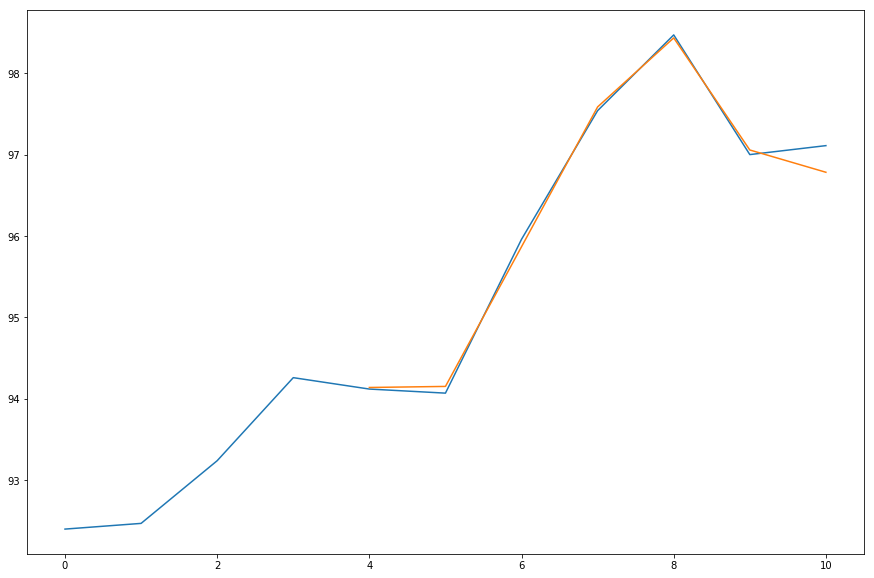

In [12]:
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(ds1)
plt.plot(ds2)
plt.show()

In [13]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=["Close"], engine='python', skipfooter=3)

numebr_of_days = 3
first_day = len(df) - 1000  # Same start date that we used for the polynomial regression
res_actuals, res_predicted = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=5000, plot=False, loss_threshold=1e-04)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))
print("Root MSE: {}".format(root_mse))

Training day 0/3
5000
epoch 1
Epoch 1/1
 - 3s - loss: 0.0866
epoch 2
Epoch 1/1
 - 0s - loss: 0.0770
epoch 3
Epoch 1/1
 - 0s - loss: 0.0689
epoch 4
Epoch 1/1
 - 0s - loss: 0.0622
epoch 5
Epoch 1/1
 - 0s - loss: 0.0565
epoch 6
Epoch 1/1
 - 0s - loss: 0.0517
epoch 7
Epoch 1/1
 - 0s - loss: 0.0478
epoch 8
Epoch 1/1
 - 0s - loss: 0.0446
epoch 9
Epoch 1/1
 - 0s - loss: 0.0422
epoch 10
Epoch 1/1
 - 0s - loss: 0.0403
epoch 11
Epoch 1/1
 - 0s - loss: 0.0390
epoch 12
Epoch 1/1
 - 0s - loss: 0.0381
epoch 13
Epoch 1/1
 - 0s - loss: 0.0376
epoch 14
Epoch 1/1
 - 0s - loss: 0.0372
epoch 15
Epoch 1/1
 - 0s - loss: 0.0370
epoch 16
Epoch 1/1
 - 0s - loss: 0.0369
epoch 17
Epoch 1/1
 - 0s - loss: 0.0368
epoch 18
Epoch 1/1
 - 0s - loss: 0.0366
epoch 19
Epoch 1/1
 - 0s - loss: 0.0365
epoch 20
Epoch 1/1
 - 0s - loss: 0.0364
epoch 21
Epoch 1/1
 - 0s - loss: 0.0363
epoch 22
Epoch 1/1
 - 0s - loss: 0.0361
epoch 23
Epoch 1/1
 - 0s - loss: 0.0360
epoch 24
Epoch 1/1
 - 0s - loss: 0.0358
epoch 25
Epoch 1/1
 - 0s - 

epoch 203
Epoch 1/1
 - 0s - loss: 0.0061
epoch 204
Epoch 1/1
 - 0s - loss: 0.0060
epoch 205
Epoch 1/1
 - 0s - loss: 0.0059
epoch 206
Epoch 1/1
 - 0s - loss: 0.0058
epoch 207
Epoch 1/1
 - 0s - loss: 0.0057
epoch 208
Epoch 1/1
 - 0s - loss: 0.0057
epoch 209
Epoch 1/1
 - 0s - loss: 0.0056
epoch 210
Epoch 1/1
 - 0s - loss: 0.0055
epoch 211
Epoch 1/1
 - 0s - loss: 0.0054
epoch 212
Epoch 1/1
 - 0s - loss: 0.0053
epoch 213
Epoch 1/1
 - 0s - loss: 0.0052
epoch 214
Epoch 1/1
 - 0s - loss: 0.0051
epoch 215
Epoch 1/1
 - 0s - loss: 0.0050
epoch 216
Epoch 1/1
 - 0s - loss: 0.0049
epoch 217
Epoch 1/1
 - 0s - loss: 0.0047
epoch 218
Epoch 1/1
 - 0s - loss: 0.0048
epoch 219
Epoch 1/1
 - 0s - loss: 0.0044
epoch 220
Epoch 1/1
 - 0s - loss: 0.0048
epoch 221
Epoch 1/1
 - 0s - loss: 0.0039
epoch 222
Epoch 1/1
 - 0s - loss: 0.0058
epoch 223
Epoch 1/1
 - 0s - loss: 0.0033
epoch 224
Epoch 1/1
 - 0s - loss: 0.0119
epoch 225
Epoch 1/1
 - 0s - loss: 0.0079
epoch 226
Epoch 1/1
 - 0s - loss: 0.0032
epoch 227
Epoch 

epoch 403
Epoch 1/1
 - 0s - loss: 0.0054
epoch 404
Epoch 1/1
 - 0s - loss: 0.0054
epoch 405
Epoch 1/1
 - 0s - loss: 0.0054
epoch 406
Epoch 1/1
 - 0s - loss: 0.0054
epoch 407
Epoch 1/1
 - 0s - loss: 0.0054
epoch 408
Epoch 1/1
 - 0s - loss: 0.0054
epoch 409
Epoch 1/1
 - 0s - loss: 0.0054
epoch 410
Epoch 1/1
 - 0s - loss: 0.0054
epoch 411
Epoch 1/1
 - 0s - loss: 0.0054
epoch 412
Epoch 1/1
 - 0s - loss: 0.0054
epoch 413
Epoch 1/1
 - 0s - loss: 0.0054
epoch 414
Epoch 1/1
 - 0s - loss: 0.0054
epoch 415
Epoch 1/1
 - 0s - loss: 0.0054
epoch 416
Epoch 1/1
 - 0s - loss: 0.0054
epoch 417
Epoch 1/1
 - 0s - loss: 0.0054
epoch 418
Epoch 1/1
 - 0s - loss: 0.0054
epoch 419
Epoch 1/1
 - 0s - loss: 0.0054
epoch 420
Epoch 1/1
 - 0s - loss: 0.0054
epoch 421
Epoch 1/1
 - 0s - loss: 0.0054
epoch 422
Epoch 1/1
 - 0s - loss: 0.0054
epoch 423
Epoch 1/1
 - 0s - loss: 0.0054
epoch 424
Epoch 1/1
 - 0s - loss: 0.0054
epoch 425
Epoch 1/1
 - 0s - loss: 0.0054
epoch 426
Epoch 1/1
 - 0s - loss: 0.0054
epoch 427
Epoch 

epoch 603
Epoch 1/1
 - 0s - loss: 0.0051
epoch 604
Epoch 1/1
 - 0s - loss: 0.0051
epoch 605
Epoch 1/1
 - 0s - loss: 0.0051
epoch 606
Epoch 1/1
 - 0s - loss: 0.0050
epoch 607
Epoch 1/1
 - 0s - loss: 0.0050
epoch 608
Epoch 1/1
 - 0s - loss: 0.0050
epoch 609
Epoch 1/1
 - 0s - loss: 0.0050
epoch 610
Epoch 1/1
 - 0s - loss: 0.0050
epoch 611
Epoch 1/1
 - 0s - loss: 0.0050
epoch 612
Epoch 1/1
 - 0s - loss: 0.0050
epoch 613
Epoch 1/1
 - 0s - loss: 0.0050
epoch 614
Epoch 1/1
 - 0s - loss: 0.0050
epoch 615
Epoch 1/1
 - 0s - loss: 0.0050
epoch 616
Epoch 1/1
 - 0s - loss: 0.0050
epoch 617
Epoch 1/1
 - 0s - loss: 0.0050
epoch 618
Epoch 1/1
 - 0s - loss: 0.0050
epoch 619
Epoch 1/1
 - 0s - loss: 0.0050
epoch 620
Epoch 1/1
 - 0s - loss: 0.0050
epoch 621
Epoch 1/1
 - 0s - loss: 0.0050
epoch 622
Epoch 1/1
 - 0s - loss: 0.0050
epoch 623
Epoch 1/1
 - 0s - loss: 0.0050
epoch 624
Epoch 1/1
 - 0s - loss: 0.0050
epoch 625
Epoch 1/1
 - 0s - loss: 0.0050
epoch 626
Epoch 1/1
 - 0s - loss: 0.0050
epoch 627
Epoch 

epoch 803
Epoch 1/1
 - 0s - loss: 0.0026
epoch 804
Epoch 1/1
 - 0s - loss: 0.0025
epoch 805
Epoch 1/1
 - 0s - loss: 0.0025
epoch 806
Epoch 1/1
 - 0s - loss: 0.0025
epoch 807
Epoch 1/1
 - 0s - loss: 0.0024
epoch 808
Epoch 1/1
 - 0s - loss: 0.0024
epoch 809
Epoch 1/1
 - 0s - loss: 0.0024
epoch 810
Epoch 1/1
 - 0s - loss: 0.0024
epoch 811
Epoch 1/1
 - 0s - loss: 0.0023
epoch 812
Epoch 1/1
 - 0s - loss: 0.0023
epoch 813
Epoch 1/1
 - 0s - loss: 0.0023
epoch 814
Epoch 1/1
 - 0s - loss: 0.0022
epoch 815
Epoch 1/1
 - 0s - loss: 0.0022
epoch 816
Epoch 1/1
 - 0s - loss: 0.0022
epoch 817
Epoch 1/1
 - 0s - loss: 0.0021
epoch 818
Epoch 1/1
 - 0s - loss: 0.0021
epoch 819
Epoch 1/1
 - 0s - loss: 0.0021
epoch 820
Epoch 1/1
 - 0s - loss: 0.0021
epoch 821
Epoch 1/1
 - 0s - loss: 0.0020
epoch 822
Epoch 1/1
 - 0s - loss: 0.0020
epoch 823
Epoch 1/1
 - 0s - loss: 0.0020
epoch 824
Epoch 1/1
 - 0s - loss: 0.0019
epoch 825
Epoch 1/1
 - 0s - loss: 0.0019
epoch 826
Epoch 1/1
 - 0s - loss: 0.0019
epoch 827
Epoch 

epoch 995
Epoch 1/1
 - 0s - loss: 9.3210e-04
epoch 996
Epoch 1/1
 - 0s - loss: 4.6320e-04
epoch 997
Epoch 1/1
 - 0s - loss: 0.0026
epoch 998
Epoch 1/1
 - 0s - loss: 2.1988e-04
epoch 999
Epoch 1/1
 - 0s - loss: 0.0028
epoch 1000
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1001
Epoch 1/1
 - 0s - loss: 0.0019
epoch 1002
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1003
Epoch 1/1
 - 0s - loss: 6.6830e-04
epoch 1004
Epoch 1/1
 - 0s - loss: 0.0070
epoch 1005
Epoch 1/1
 - 0s - loss: 4.0800e-04
epoch 1006
Epoch 1/1
 - 0s - loss: 0.0067
epoch 1007
Epoch 1/1
 - 0s - loss: 4.4265e-04
epoch 1008
Epoch 1/1
 - 0s - loss: 0.0070
epoch 1009
Epoch 1/1
 - 0s - loss: 4.2615e-04
epoch 1010
Epoch 1/1
 - 0s - loss: 0.0055
epoch 1011
Epoch 1/1
 - 0s - loss: 5.9610e-04
epoch 1012
Epoch 1/1
 - 0s - loss: 0.0050
epoch 1013
Epoch 1/1
 - 0s - loss: 0.0010
epoch 1014
Epoch 1/1
 - 0s - loss: 0.0033
epoch 1015
Epoch 1/1
 - 0s - loss: 0.0012
epoch 1016
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1017
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1

epoch 1181
Epoch 1/1
 - 0s - loss: 2.6522e-04
epoch 1182
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1183
Epoch 1/1
 - 0s - loss: 2.5981e-04
epoch 1184
Epoch 1/1
 - 0s - loss: 0.0020
epoch 1185
Epoch 1/1
 - 0s - loss: 3.5113e-04
epoch 1186
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1187
Epoch 1/1
 - 0s - loss: 3.5363e-04
epoch 1188
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1189
Epoch 1/1
 - 0s - loss: 5.5274e-04
epoch 1190
Epoch 1/1
 - 0s - loss: 0.0017
epoch 1191
Epoch 1/1
 - 0s - loss: 5.9342e-04
epoch 1192
Epoch 1/1
 - 0s - loss: 0.0020
epoch 1193
Epoch 1/1
 - 0s - loss: 8.8133e-04
epoch 1194
Epoch 1/1
 - 0s - loss: 0.0015
epoch 1195
Epoch 1/1
 - 0s - loss: 9.6903e-04
epoch 1196
Epoch 1/1
 - 0s - loss: 0.0017
epoch 1197
Epoch 1/1
 - 0s - loss: 0.0013
epoch 1198
Epoch 1/1
 - 0s - loss: 0.0010
epoch 1199
Epoch 1/1
 - 0s - loss: 0.0014
epoch 1200
Epoch 1/1
 - 0s - loss: 0.0012
epoch 1201
Epoch 1/1
 - 0s - loss: 0.0016
epoch 1202
Epoch 1/1
 - 0s - loss: 5.5077e-04
epoch 1203
Epoch 1/1
 - 0s - loss: 0.001

epoch 1368
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1369
Epoch 1/1
 - 0s - loss: 5.2206e-04
epoch 1370
Epoch 1/1
 - 0s - loss: 0.0014
epoch 1371
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1372
Epoch 1/1
 - 0s - loss: 0.0010
epoch 1373
Epoch 1/1
 - 0s - loss: 0.0019
epoch 1374
Epoch 1/1
 - 0s - loss: 2.1098e-04
epoch 1375
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1376
Epoch 1/1
 - 0s - loss: 1.8630e-04
epoch 1377
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1378
Epoch 1/1
 - 0s - loss: 7.3482e-04
epoch 1379
Epoch 1/1
 - 0s - loss: 0.0012
epoch 1380
Epoch 1/1
 - 0s - loss: 0.0014
epoch 1381
Epoch 1/1
 - 0s - loss: 8.4767e-04
epoch 1382
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1383
Epoch 1/1
 - 0s - loss: 1.6550e-04
epoch 1384
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1385
Epoch 1/1
 - 0s - loss: 2.9951e-04
epoch 1386
Epoch 1/1
 - 0s - loss: 0.0019
epoch 1387
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1388
Epoch 1/1
 - 0s - loss: 7.5236e-04
epoch 1389
Epoch 1/1
 - 0s - loss: 0.0019
epoch 1390
Epoch 1/1
 - 0s - loss: 3.5588e-0

epoch 1557
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1558
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1559
Epoch 1/1
 - 0s - loss: 8.7013e-04
epoch 1560
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1561
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1562
Epoch 1/1
 - 0s - loss: 4.5043e-04
epoch 1563
Epoch 1/1
 - 0s - loss: 0.0035
epoch 1564
Epoch 1/1
 - 0s - loss: 0.0044
epoch 1565
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1566
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1567
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1568
Epoch 1/1
 - 0s - loss: 0.0015
epoch 1569
Epoch 1/1
 - 0s - loss: 0.0013
epoch 1570
Epoch 1/1
 - 0s - loss: 0.0044
epoch 1571
Epoch 1/1
 - 0s - loss: 0.0038
epoch 1572
Epoch 1/1
 - 0s - loss: 0.0013
epoch 1573
Epoch 1/1
 - 0s - loss: 0.0031
epoch 1574
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1575
Epoch 1/1
 - 0s - loss: 9.5585e-04
epoch 1576
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1577
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1578
Epoch 1/1
 - 0s - loss: 0.0033
epoch 1579
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1580
Epoch 1/1
 

epoch 1749
Epoch 1/1
 - 0s - loss: 0.0015
epoch 1750
Epoch 1/1
 - 0s - loss: 0.0034
epoch 1751
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1752
Epoch 1/1
 - 0s - loss: 6.2280e-04
epoch 1753
Epoch 1/1
 - 0s - loss: 0.0021
epoch 1754
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1755
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1756
Epoch 1/1
 - 0s - loss: 9.4566e-04
epoch 1757
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1758
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1759
Epoch 1/1
 - 0s - loss: 0.0010
epoch 1760
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1761
Epoch 1/1
 - 0s - loss: 0.0033
epoch 1762
Epoch 1/1
 - 0s - loss: 0.0037
epoch 1763
Epoch 1/1
 - 0s - loss: 0.0013
epoch 1764
Epoch 1/1
 - 0s - loss: 0.0017
epoch 1765
Epoch 1/1
 - 0s - loss: 0.0032
epoch 1766
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1767
Epoch 1/1
 - 0s - loss: 6.2787e-04
epoch 1768
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1769
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1770
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1771
Epoch 1/1
 - 0s - loss: 9.5173e-04
epoch 1772
Epoch 1

epoch 1941
Epoch 1/1
 - 0s - loss: 6.3423e-04
epoch 1942
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1943
Epoch 1/1
 - 0s - loss: 0.0044
epoch 1944
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1945
Epoch 1/1
 - 0s - loss: 9.8386e-04
epoch 1946
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1947
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1948
Epoch 1/1
 - 0s - loss: 9.5607e-04
epoch 1949
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1950
Epoch 1/1
 - 0s - loss: 0.0036
epoch 1951
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1952
Epoch 1/1
 - 0s - loss: 0.0012
epoch 1953
Epoch 1/1
 - 0s - loss: 0.0017
epoch 1954
Epoch 1/1
 - 0s - loss: 0.0031
epoch 1955
Epoch 1/1
 - 0s - loss: 0.0020
epoch 1956
Epoch 1/1
 - 0s - loss: 6.7584e-04
epoch 1957
Epoch 1/1
 - 0s - loss: 0.0018
epoch 1958
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1959
Epoch 1/1
 - 0s - loss: 0.0034
epoch 1960
Epoch 1/1
 - 0s - loss: 8.4121e-04
epoch 1961
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1962
Epoch 1/1
 - 0s - loss: 0.0029
epoch 1963
Epoch 1/1
 - 0s - loss: 0.0014
epoch 1964
Epo

epoch 2132
Epoch 1/1
 - 0s - loss: 0.0038
epoch 2133
Epoch 1/1
 - 0s - loss: 0.0026
epoch 2134
Epoch 1/1
 - 0s - loss: 6.8748e-04
epoch 2135
Epoch 1/1
 - 0s - loss: 0.0023
epoch 2136
Epoch 1/1
 - 0s - loss: 0.0023
epoch 2137
Epoch 1/1
 - 0s - loss: 9.2736e-04
epoch 2138
Epoch 1/1
 - 0s - loss: 6.8677e-04
epoch 2139
Epoch 1/1
 - 0s - loss: 0.0026
epoch 2140
Epoch 1/1
 - 0s - loss: 0.0036
epoch 2141
Epoch 1/1
 - 0s - loss: 0.0011
epoch 2142
Epoch 1/1
 - 0s - loss: 0.0012
epoch 2143
Epoch 1/1
 - 0s - loss: 0.0024
epoch 2144
Epoch 1/1
 - 0s - loss: 0.0016
epoch 2145
Epoch 1/1
 - 0s - loss: 5.1554e-04
epoch 2146
Epoch 1/1
 - 0s - loss: 0.0013
epoch 2147
Epoch 1/1
 - 0s - loss: 0.0033
epoch 2148
Epoch 1/1
 - 0s - loss: 0.0024
epoch 2149
Epoch 1/1
 - 0s - loss: 6.0951e-04
epoch 2150
Epoch 1/1
 - 0s - loss: 0.0020
epoch 2151
Epoch 1/1
 - 0s - loss: 0.0021
epoch 2152
Epoch 1/1
 - 0s - loss: 8.4517e-04
epoch 2153
Epoch 1/1
 - 0s - loss: 6.3052e-04
epoch 2154
Epoch 1/1
 - 0s - loss: 0.0025
epoch 

epoch 2321
Epoch 1/1
 - 0s - loss: 4.3002e-04
epoch 2322
Epoch 1/1
 - 0s - loss: 0.0013
epoch 2323
Epoch 1/1
 - 0s - loss: 0.0013
epoch 2324
Epoch 1/1
 - 0s - loss: 3.5637e-04
epoch 2325
Epoch 1/1
 - 0s - loss: 9.1033e-04
epoch 2326
Epoch 1/1
 - 0s - loss: 8.5086e-04
epoch 2327
Epoch 1/1
 - 0s - loss: 3.0110e-04
epoch 2328
Epoch 1/1
 - 0s - loss: 4.1956e-04
epoch 2329
Epoch 1/1
 - 0s - loss: 0.0012
epoch 2330
Epoch 1/1
 - 0s - loss: 0.0011
epoch 2331
Epoch 1/1
 - 0s - loss: 3.3073e-04
epoch 2332
Epoch 1/1
 - 0s - loss: 8.8946e-04
epoch 2333
Epoch 1/1
 - 0s - loss: 6.9152e-04
epoch 2334
Epoch 1/1
 - 0s - loss: 2.3545e-04
epoch 2335
Epoch 1/1
 - 0s - loss: 4.9601e-04
epoch 2336
Epoch 1/1
 - 0s - loss: 0.0012
epoch 2337
Epoch 1/1
 - 0s - loss: 7.9270e-04
epoch 2338
Epoch 1/1
 - 0s - loss: 3.8390e-04
epoch 2339
Epoch 1/1
 - 0s - loss: 9.5869e-04
epoch 2340
Epoch 1/1
 - 0s - loss: 5.2330e-04
epoch 2341
Epoch 1/1
 - 0s - loss: 2.1190e-04
epoch 2342
Epoch 1/1
 - 0s - loss: 7.5756e-04
epoch 23

epoch 37
Epoch 1/1
 - 0s - loss: 0.0260
epoch 38
Epoch 1/1
 - 0s - loss: 0.0258
epoch 39
Epoch 1/1
 - 0s - loss: 0.0257
epoch 40
Epoch 1/1
 - 0s - loss: 0.0255
epoch 41
Epoch 1/1
 - 0s - loss: 0.0253
epoch 42
Epoch 1/1
 - 0s - loss: 0.0251
epoch 43
Epoch 1/1
 - 0s - loss: 0.0250
epoch 44
Epoch 1/1
 - 0s - loss: 0.0248
epoch 45
Epoch 1/1
 - 0s - loss: 0.0246
epoch 46
Epoch 1/1
 - 0s - loss: 0.0245
epoch 47
Epoch 1/1
 - 0s - loss: 0.0243
epoch 48
Epoch 1/1
 - 0s - loss: 0.0241
epoch 49
Epoch 1/1
 - 0s - loss: 0.0239
epoch 50
Epoch 1/1
 - 0s - loss: 0.0237
epoch 51
Epoch 1/1
 - 0s - loss: 0.0235
epoch 52
Epoch 1/1
 - 0s - loss: 0.0234
epoch 53
Epoch 1/1
 - 0s - loss: 0.0232
epoch 54
Epoch 1/1
 - 0s - loss: 0.0230
epoch 55
Epoch 1/1
 - 0s - loss: 0.0228
epoch 56
Epoch 1/1
 - 0s - loss: 0.0226
epoch 57
Epoch 1/1
 - 0s - loss: 0.0224
epoch 58
Epoch 1/1
 - 0s - loss: 0.0222
epoch 59
Epoch 1/1
 - 0s - loss: 0.0220
epoch 60
Epoch 1/1
 - 0s - loss: 0.0218
epoch 61
Epoch 1/1
 - 0s - loss: 0.0216


epoch 239
Epoch 1/1
 - 0s - loss: 0.0020
epoch 240
Epoch 1/1
 - 0s - loss: 0.0020
epoch 241
Epoch 1/1
 - 0s - loss: 0.0020
epoch 242
Epoch 1/1
 - 0s - loss: 0.0020
epoch 243
Epoch 1/1
 - 0s - loss: 0.0020
epoch 244
Epoch 1/1
 - 0s - loss: 0.0020
epoch 245
Epoch 1/1
 - 0s - loss: 0.0020
epoch 246
Epoch 1/1
 - 0s - loss: 0.0020
epoch 247
Epoch 1/1
 - 0s - loss: 0.0020
epoch 248
Epoch 1/1
 - 0s - loss: 0.0020
epoch 249
Epoch 1/1
 - 0s - loss: 0.0020
epoch 250
Epoch 1/1
 - 0s - loss: 0.0020
epoch 251
Epoch 1/1
 - 0s - loss: 0.0020
epoch 252
Epoch 1/1
 - 0s - loss: 0.0020
epoch 253
Epoch 1/1
 - 0s - loss: 0.0020
epoch 254
Epoch 1/1
 - 0s - loss: 0.0020
epoch 255
Epoch 1/1
 - 0s - loss: 0.0020
epoch 256
Epoch 1/1
 - 0s - loss: 0.0020
epoch 257
Epoch 1/1
 - 0s - loss: 0.0020
epoch 258
Epoch 1/1
 - 0s - loss: 0.0020
epoch 259
Epoch 1/1
 - 0s - loss: 0.0020
epoch 260
Epoch 1/1
 - 0s - loss: 0.0020
epoch 261
Epoch 1/1
 - 0s - loss: 0.0020
epoch 262
Epoch 1/1
 - 0s - loss: 0.0020
epoch 263
Epoch 

epoch 439
Epoch 1/1
 - 0s - loss: 0.0015
epoch 440
Epoch 1/1
 - 0s - loss: 0.0015
epoch 441
Epoch 1/1
 - 0s - loss: 0.0015
epoch 442
Epoch 1/1
 - 0s - loss: 0.0015
epoch 443
Epoch 1/1
 - 0s - loss: 0.0015
epoch 444
Epoch 1/1
 - 0s - loss: 0.0015
epoch 445
Epoch 1/1
 - 0s - loss: 0.0015
epoch 446
Epoch 1/1
 - 0s - loss: 0.0015
epoch 447
Epoch 1/1
 - 0s - loss: 0.0015
epoch 448
Epoch 1/1
 - 0s - loss: 0.0015
epoch 449
Epoch 1/1
 - 0s - loss: 0.0015
epoch 450
Epoch 1/1
 - 0s - loss: 0.0015
epoch 451
Epoch 1/1
 - 0s - loss: 0.0015
epoch 452
Epoch 1/1
 - 0s - loss: 0.0015
epoch 453
Epoch 1/1
 - 0s - loss: 0.0015
epoch 454
Epoch 1/1
 - 0s - loss: 0.0015
epoch 455
Epoch 1/1
 - 0s - loss: 0.0015
epoch 456
Epoch 1/1
 - 0s - loss: 0.0015
epoch 457
Epoch 1/1
 - 0s - loss: 0.0015
epoch 458
Epoch 1/1
 - 0s - loss: 0.0015
epoch 459
Epoch 1/1
 - 0s - loss: 0.0015
epoch 460
Epoch 1/1
 - 0s - loss: 0.0015
epoch 461
Epoch 1/1
 - 0s - loss: 0.0015
epoch 462
Epoch 1/1
 - 0s - loss: 0.0015
epoch 463
Epoch 

epoch 633
Epoch 1/1
 - 0s - loss: 7.9386e-04
epoch 634
Epoch 1/1
 - 0s - loss: 7.9600e-04
epoch 635
Epoch 1/1
 - 0s - loss: 7.9878e-04
epoch 636
Epoch 1/1
 - 0s - loss: 8.0220e-04
epoch 637
Epoch 1/1
 - 0s - loss: 8.0651e-04
epoch 638
Epoch 1/1
 - 0s - loss: 8.1181e-04
epoch 639
Epoch 1/1
 - 0s - loss: 8.1805e-04
epoch 640
Epoch 1/1
 - 0s - loss: 8.2549e-04
epoch 641
Epoch 1/1
 - 0s - loss: 8.3442e-04
epoch 642
Epoch 1/1
 - 0s - loss: 8.4482e-04
epoch 643
Epoch 1/1
 - 0s - loss: 8.5695e-04
epoch 644
Epoch 1/1
 - 0s - loss: 8.7135e-04
epoch 645
Epoch 1/1
 - 0s - loss: 8.8811e-04
epoch 646
Epoch 1/1
 - 0s - loss: 9.0757e-04
epoch 647
Epoch 1/1
 - 0s - loss: 9.3066e-04
epoch 648
Epoch 1/1
 - 0s - loss: 9.5765e-04
epoch 649
Epoch 1/1
 - 0s - loss: 9.9124e-04
epoch 650
Epoch 1/1
 - 0s - loss: 0.0010
epoch 651
Epoch 1/1
 - 0s - loss: 0.0011
epoch 652
Epoch 1/1
 - 0s - loss: 0.0011
epoch 653
Epoch 1/1
 - 0s - loss: 0.0011
epoch 654
Epoch 1/1
 - 0s - loss: 0.0012
epoch 655
Epoch 1/1
 - 0s - lo

 - 0s - loss: 4.9207e-04
epoch 827
Epoch 1/1
 - 0s - loss: 6.3350e-04
epoch 828
Epoch 1/1
 - 0s - loss: 0.0012
epoch 829
Epoch 1/1
 - 0s - loss: 5.8424e-04
epoch 830
Epoch 1/1
 - 0s - loss: 0.0013
epoch 831
Epoch 1/1
 - 0s - loss: 7.0378e-04
epoch 832
Epoch 1/1
 - 0s - loss: 0.0013
epoch 833
Epoch 1/1
 - 0s - loss: 7.2139e-04
epoch 834
Epoch 1/1
 - 0s - loss: 4.0920e-04
epoch 835
Epoch 1/1
 - 0s - loss: 0.0012
epoch 836
Epoch 1/1
 - 0s - loss: 4.0518e-04
epoch 837
Epoch 1/1
 - 0s - loss: 0.0011
epoch 838
Epoch 1/1
 - 0s - loss: 9.2699e-04
epoch 839
Epoch 1/1
 - 0s - loss: 0.0010
epoch 840
Epoch 1/1
 - 0s - loss: 0.0010
epoch 841
Epoch 1/1
 - 0s - loss: 3.8019e-04
epoch 842
Epoch 1/1
 - 0s - loss: 0.0013
epoch 843
Epoch 1/1
 - 0s - loss: 3.9320e-04
epoch 844
Epoch 1/1
 - 0s - loss: 7.3889e-04
epoch 845
Epoch 1/1
 - 0s - loss: 0.0011
epoch 846
Epoch 1/1
 - 0s - loss: 6.7917e-04
epoch 847
Epoch 1/1
 - 0s - loss: 0.0013
epoch 848
Epoch 1/1
 - 0s - loss: 5.3794e-04
epoch 849
Epoch 1/1
 - 0s

 - 0s - loss: 5.0129e-04
epoch 1011
Epoch 1/1
 - 0s - loss: 1.1187e-04
epoch 1012
Epoch 1/1
 - 0s - loss: 3.2471e-04
epoch 1013
Epoch 1/1
 - 0s - loss: 4.3614e-04
epoch 1014
Epoch 1/1
 - 0s - loss: 2.7327e-04
epoch 1015
Epoch 1/1
 - 0s - loss: 5.2214e-04
epoch 1016
Epoch 1/1
 - 0s - loss: 2.2203e-04
epoch 1017
Epoch 1/1
 - 0s - loss: 4.9430e-04
epoch 1018
Epoch 1/1
 - 0s - loss: 2.9515e-04
epoch 1019
Epoch 1/1
 - 0s - loss: 1.0345e-04
epoch 1020
Epoch 1/1
 - 0s - loss: 5.4609e-04
epoch 1021
Epoch 1/1
 - 0s - loss: 1.0352e-04
epoch 1022
Epoch 1/1
 - 0s - loss: 3.5715e-04
epoch 1023
Epoch 1/1
 - 0s - loss: 4.7865e-04
epoch 1024
Epoch 1/1
 - 0s - loss: 2.9800e-04
epoch 1025
Epoch 1/1
 - 0s - loss: 5.6992e-04
epoch 1026
Epoch 1/1
 - 0s - loss: 2.3080e-04
epoch 1027
Epoch 1/1
 - 0s - loss: 5.3924e-04
epoch 1028
Epoch 1/1
 - 0s - loss: 2.9277e-04
epoch 1029
Epoch 1/1
 - 0s - loss: 1.0031e-04
epoch 1030
Epoch 1/1
 - 0s - loss: 5.7908e-04
epoch 1031
Epoch 1/1
 - 0s - loss: 9.6626e-05
Loss is l

epoch 177
Epoch 1/1
 - 0s - loss: 0.0091
epoch 178
Epoch 1/1
 - 0s - loss: 0.0090
epoch 179
Epoch 1/1
 - 0s - loss: 0.0089
epoch 180
Epoch 1/1
 - 0s - loss: 0.0088
epoch 181
Epoch 1/1
 - 0s - loss: 0.0087
epoch 182
Epoch 1/1
 - 0s - loss: 0.0086
epoch 183
Epoch 1/1
 - 0s - loss: 0.0085
epoch 184
Epoch 1/1
 - 0s - loss: 0.0084
epoch 185
Epoch 1/1
 - 0s - loss: 0.0083
epoch 186
Epoch 1/1
 - 0s - loss: 0.0082
epoch 187
Epoch 1/1
 - 0s - loss: 0.0081
epoch 188
Epoch 1/1
 - 0s - loss: 0.0080
epoch 189
Epoch 1/1
 - 0s - loss: 0.0079
epoch 190
Epoch 1/1
 - 0s - loss: 0.0078
epoch 191
Epoch 1/1
 - 0s - loss: 0.0078
epoch 192
Epoch 1/1
 - 0s - loss: 0.0077
epoch 193
Epoch 1/1
 - 0s - loss: 0.0076
epoch 194
Epoch 1/1
 - 0s - loss: 0.0075
epoch 195
Epoch 1/1
 - 0s - loss: 0.0074
epoch 196
Epoch 1/1
 - 0s - loss: 0.0072
epoch 197
Epoch 1/1
 - 0s - loss: 0.0071
epoch 198
Epoch 1/1
 - 0s - loss: 0.0070
epoch 199
Epoch 1/1
 - 0s - loss: 0.0069
epoch 200
Epoch 1/1
 - 0s - loss: 0.0068
epoch 201
Epoch 

## Speeding up
### Performance issues
I encountered a serious performance issue. Training a single day takes a couple of minutes.
<br>
There are 3000 epochs that needed to get to a low loss value and RMSE.
<br>
It will take a couple of days to train 1,000 days and get results.
<br>
Undoubtedly performance improvement needed.

### Utilizing the hardware
The models are trained on my Lenovo T460P laptop. It's a Intel Core i7 with 8 cores.
<br>
However only 1 core out of 8 was running on 100% cpu while training the model.
<br>
Here are some ways that I tried speedup training:
- Use GPUs for Tensorflow backend > it seems that my laptop doesn't have an nVidia card installed
- Use tensorflow session settings to control number of CPUs used > didn't help
- Split the code to array of trained days to batches and run all of them in parallel by using Python multiprocessing > the code did run in parallel, but still only a single CPU was used
- Run on a machine in Amazon with GPU enabled > not an option - it founds out to be very expensive
- Run the epochs inside the model instead doing it externally and fitting with just 1 epoch > same results

I think that the problem is that epochs need to run sequentially, so the parallelism is done inside every epoch. 
<br>
But the network is so small and the number of samples is so small (only 10 with a window of 10), that the training of the epoch is finishing before getting to utilize all cores.

### Improving the model
Some ways to improve the LSTM network in order to gain performance improvement:
- Dropout - Tried to add a Dropout layer after each LSTM layer in order to drop weights of random neurons. This way neurons will penalized and the model won't overfit. I found out that it doesn't improve the training performance, and it's more useful to penalize features that don't have impact, however we have just a single feature. Maybe I'll try it later when trying more features.
- Regularization - I tried to use an L2 regularization on the output layer. I tried all kinds of factors, but it didn't help much except reaching high loss.
- Optimizer - Here comes the big improvement. I changed Adam optimizer with RMSprop and tried all kinds of learning rates and found out that when increasing the learning rate, the loss value advances fatser, but it also goes up and down and fails to reach the minimum - as expected. But we don't need to reach the minimum!

### The results
The network configuration that I came up with and has a good training performance:
- No regularization
- No dropout
- RMSProp optimizer with learning rate 0.005
- Running 600 epochs or when reaching loss value of 0.001 - the first that occurs

With this configuration, the model is reaching a pretty low loss value after 250 epochs on average.
<br>
My feeling is that a stock graph is not repetitive and doesn't have a clear pattern, so it won't help to let the model generalize.
<br>
That's why overfitting might be the best solution.
<br>
On the other hand it seems that overfitting (like in the plot above) doesn't give much better RMSE values for the test set than when the model is generalized.
<br>
It means that instead of running 3000 epochs to have a very low loss value and overfit the network, we can just run 250 epochs, the model won't overfit and will give more or less the same RMSE values.

### The complete code with the described settings and with some bug fixes for calculating RMSE:

In [3]:
def predict_close_lstm(df, cur_day, num_of_days, window_size=10, look_back=4, epochs=100, plot=False, plot_callback=None, loss_threshold=1e-4):
    actuals = []
    predictions = []

    def run_dataset_portion(start, end):
        # Go through all requested days and make a new training for every day
        for i in range(start, end):
            print("Training day {}".format(i - start))
            # For each day, train a new model using Close values of previous days.
            # Number of previous days is defined by "window_size"
            samples_start = i - window_size
            samples_end = i - 1

            # Important!
            # The training set will be taken from [samples_start:samples_end + 1]
            # and the last sample is for the prediction of next day
            df_cur_dataset = df[samples_start:samples_end + 2]

            actual, predicted = train_lstm(df_cur_dataset, look_back, epochs, plot=plot, plot_callback=plot_callback, loss_threshold=loss_threshold)
            actuals.append(actual)
            predictions.append(predicted)

        return actuals, predictions

    return run_dataset_portion(cur_day, cur_day + num_of_days)

    # Running in batches - A try for running portions of dataset in parallel
    # start = cur_day
    # end = cur_day + num_of_days
    # num_of_portions = 4
    # total_per_portion = math.floor(end - start / num_of_portions)
    # from multiprocessing import Process
    # for i in range(0, num_of_portions):
    #     portion_start_sample = start + (i * total_per_portion)
    #     Process(target=run_dataset_portion, args=(portion_start_sample, portion_start_sample + total_per_portion)).start()
    # import time
    # time.sleep(100000)


def train_lstm(df, look_back, epochs, plot=False, plot_callback=None, loss_threshold=10**-4):
    # Set multi cores and print cores info
    # tf_session = tf.Session(config=tf.ConfigProto(device_count={"CPU": 8}, intra_op_parallelism_threads=2, inter_op_parallelism_threads=2))
    # keras.backend.tensorflow_backend.set_session(tf_session)
    # print(tf_session)

    # Normalize the whole dataset (this will include Xs and Ys)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df.values.astype('float32'))

    # reshape into X=t and Y=t+1
    train_x, train_y, x_inc_predict, y_inc_predict = create_lstm_dataset(dataset, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    x_inc_predict = np.reshape(x_inc_predict, (x_inc_predict.shape[0], x_inc_predict.shape[1], 1))

    # Create the LSTM network
    batch_size = 1
    model = create_model(batch_size, look_back)

    # Fit the network - use multiple epochs
    for i in range(epochs):
        print("epoch {}".format(i + 1))
        res = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
        if res.history["loss"][0] < loss_threshold:
            print("Loss is lower than threshold of {}. Quitting.".format(loss_threshold))
            break

    # make predictions
    train_predict = model.predict(x_inc_predict, batch_size=batch_size)
    model.reset_states()

    # invert predictions
    train_y = scaler.inverse_transform([train_y])
    train_predict = scaler.inverse_transform(train_predict)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_y[0], train_predict[:-1, 0]))
    print('Train Score RMSE: %.2f' % (trainScore))

    # shift train predictions for plotting
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

    if plot_callback:
        plot_callback(scaler.inverse_transform(dataset), train_predict_plot)

    if plot:
        # plot baseline and predictions
        plt.figure(figsize=(15, 10))
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(train_predict_plot)
        plt.show()

    actual = df.iloc[-1]["Close"]
    predicted = train_predict[-1, 0]

    return actual, predicted


def create_model(batch_size, look_back, regularization_factor=0, dropout=False, custom_optimizer=True):
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(regularization_factor)))

    if custom_optimizer:
        learning_rate = 0.005
        optimzer = optimizers.RMSprop(lr=learning_rate)
    else:
        optimzer = 'adam'

    model.compile(loss='mean_squared_error', optimizer=optimzer)

    return model


def create_lstm_dataset(dataset, look_back=1):
    # Actual training set
    data_x, data_y = [], []

    # X and Y sets that include the last sample (which is not part of the training set)
    # This will be used for predicting and ploting the next day
    data_inc_predict_x, data_inc_predict_y = [], []

    def add_i_features(ds_x, ds_y, i):
        # Append to the list of timeseries, a 1 dimensional array that
        # includes values of our single feature (index 0) across current look_back range
        ds_x.append(dataset[i:(i + look_back), 0])

        # Append to the list of Ys, the y of the current look_back, which is our feature
        # of next day after our look_back range
        ds_y.append(dataset[i + look_back, 0])

    # Go through all training samples
    # For example
    # if the windows size is 10
    # 11 samples will be passed
    # samples 0-9 will be used for the training set
    # sample 10 will be used for the prediction
    for i in range(len(dataset) - look_back - 1):
        add_i_features(data_x, data_y, i)
        add_i_features(data_inc_predict_x, data_inc_predict_y, i)

    # Add the last sample for prediction purposes
    add_i_features(data_inc_predict_x, data_inc_predict_y, i + 1)

    return np.array(data_x), np.array(data_y), np.array(data_inc_predict_x), np.array(data_inc_predict_y)

In [16]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=["Close"], engine='python', skipfooter=3)

##############################3

# A callback to save plot data from within the training function in order to be able to plot the data in a different cell in Jupyter.
ds1 = None
ds2 = None
def save_plot_data(original_dataset, predicted_shifted_dataset):
    global ds1
    global ds2
    ds1 = original_dataset
    ds2 = predicted_shifted_dataset
numebr_of_days = 1
first_day = int(len(df) / 2)
res_actuals, res_predicted = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=600, plot=False, plot_callback=save_plot_data, loss_threshold=1e-3)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))
print('Test Score RMSE: %.2f' % (root_mse))

Training day 0
epoch 1
Epoch 1/1
 - 3s - loss: 0.2490
epoch 2
Epoch 1/1
 - 0s - loss: 0.0561
epoch 3
Epoch 1/1
 - 0s - loss: 0.0242
epoch 4
Epoch 1/1
 - 0s - loss: 0.0230
epoch 5
Epoch 1/1
 - 0s - loss: 0.0230
epoch 6
Epoch 1/1
 - 0s - loss: 0.0228
epoch 7
Epoch 1/1
 - 0s - loss: 0.0226
epoch 8
Epoch 1/1
 - 0s - loss: 0.0223
epoch 9
Epoch 1/1
 - 0s - loss: 0.0220
epoch 10
Epoch 1/1
 - 0s - loss: 0.0217
epoch 11
Epoch 1/1
 - 0s - loss: 0.0214
epoch 12
Epoch 1/1
 - 0s - loss: 0.0211
epoch 13
Epoch 1/1
 - 0s - loss: 0.0208
epoch 14
Epoch 1/1
 - 0s - loss: 0.0205
epoch 15
Epoch 1/1
 - 0s - loss: 0.0202
epoch 16
Epoch 1/1
 - 0s - loss: 0.0200
epoch 17
Epoch 1/1
 - 0s - loss: 0.0197
epoch 18
Epoch 1/1
 - 0s - loss: 0.0195
epoch 19
Epoch 1/1
 - 0s - loss: 0.0193
epoch 20
Epoch 1/1
 - 0s - loss: 0.0190
epoch 21
Epoch 1/1
 - 0s - loss: 0.0188
epoch 22
Epoch 1/1
 - 0s - loss: 0.0186
epoch 23
Epoch 1/1
 - 0s - loss: 0.0184
epoch 24
Epoch 1/1
 - 0s - loss: 0.0182
epoch 25
Epoch 1/1
 - 0s - loss: 0

 - 0s - loss: 0.0057
epoch 204
Epoch 1/1
 - 0s - loss: 0.0044
epoch 205
Epoch 1/1
 - 0s - loss: 0.0033
epoch 206
Epoch 1/1
 - 0s - loss: 0.0030
epoch 207
Epoch 1/1
 - 0s - loss: 0.0026
epoch 208
Epoch 1/1
 - 0s - loss: 0.0033
epoch 209
Epoch 1/1
 - 0s - loss: 0.0044
epoch 210
Epoch 1/1
 - 0s - loss: 0.0068
epoch 211
Epoch 1/1
 - 0s - loss: 0.0072
epoch 212
Epoch 1/1
 - 0s - loss: 0.0058
epoch 213
Epoch 1/1
 - 0s - loss: 0.0046
epoch 214
Epoch 1/1
 - 0s - loss: 0.0027
epoch 215
Epoch 1/1
 - 0s - loss: 0.0028
epoch 216
Epoch 1/1
 - 0s - loss: 0.0021
epoch 217
Epoch 1/1
 - 0s - loss: 0.0031
epoch 218
Epoch 1/1
 - 0s - loss: 0.0044
epoch 219
Epoch 1/1
 - 0s - loss: 0.0066
epoch 220
Epoch 1/1
 - 0s - loss: 0.0056
epoch 221
Epoch 1/1
 - 0s - loss: 0.0037
epoch 222
Epoch 1/1
 - 0s - loss: 0.0031
epoch 223
Epoch 1/1
 - 0s - loss: 0.0017
epoch 224
Epoch 1/1
 - 0s - loss: 0.0020
epoch 225
Epoch 1/1
 - 0s - loss: 0.0028
epoch 226
Epoch 1/1
 - 0s - loss: 0.0062
epoch 227
Epoch 1/1
 - 0s - loss: 0.

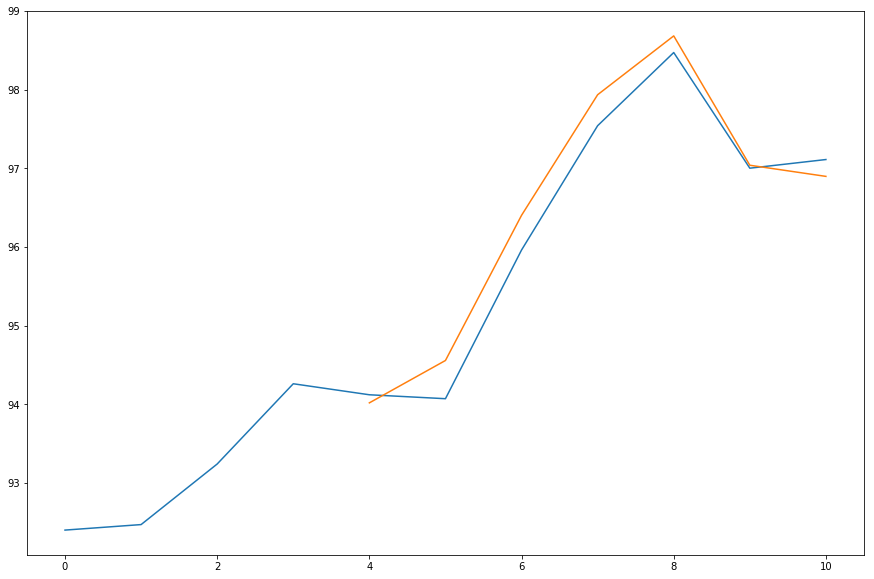

In [17]:
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(ds1)
plt.plot(ds2)
plt.show()

In [6]:
def predict_close_lstm(df, cur_day, num_of_days, window_size=10, look_back=4, epochs=100, plot=False, plot_callback=None, loss_threshold=1e-4):
    actuals = []
    predictions = []

    start = cur_day
    end = cur_day + num_of_days
    # Go through all requested days and make a new training for every day
    for i in range(start, end):
        print("Training day {}".format(i - start))
        # For each day, train a new model using Close values of previous days.
        # Number of previous days is defined by "window_size"
        samples_start = i - window_size
        samples_end = i - 1

        # Important!
        # The training set will be taken from [samples_start:samples_end + 1]
        # and the last sample is for the prediction of next day
        df_cur_dataset = df[samples_start:samples_end + 2]

        actual, predicted = train_lstm(df_cur_dataset, look_back, epochs, plot=plot, plot_callback=plot_callback, loss_threshold=loss_threshold)
        actuals.append(actual)
        predictions.append(predicted)

    # Build a DataFrame that includes the actual and predicted results on the given data set
    df_results = df.iloc[cur_day:cur_day + num_of_days]
    cols_pred = pd.Series(predictions, index=range(cur_day, cur_day + num_of_days))
    df_results["Prediction"] = pd.Series(cols_pred)

    return actuals, predictions, df_results


def train_lstm(df, look_back, epochs, plot=False, plot_callback=None, loss_threshold=10**-4):
    # Set multi cores and print cores info
    # tf_session = tf.Session(config=tf.ConfigProto(device_count={"CPU": 8}, intra_op_parallelism_threads=2, inter_op_parallelism_threads=2))
    # keras.backend.tensorflow_backend.set_session(tf_session)
    # print(tf_session)

    # Normalize the Close dataset (this will include Xs and Ys)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_vals = np.reshape(df["Close"].values, (len(df), 1))
    dataset = scaler.fit_transform(close_vals.astype('float32'))

    # reshape into X=t and Y=t+1
    train_x, train_y, x_inc_predict, y_inc_predict = create_lstm_dataset(dataset, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    x_inc_predict = np.reshape(x_inc_predict, (x_inc_predict.shape[0], x_inc_predict.shape[1], 1))

    # Create the LSTM network
    batch_size = 1
    model = create_model(batch_size, look_back)

    # Fit the network - use multiple epochs
    for i in range(epochs):
        print("epoch {}".format(i + 1))
        res = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
        if res.history["loss"][0] < loss_threshold:
            print("Loss is lower than threshold of {}. Quitting.".format(loss_threshold))
            break

    # make predictions
    train_predict = model.predict(x_inc_predict, batch_size=batch_size)
    model.reset_states()

    # invert predictions
    train_y = scaler.inverse_transform([train_y])
    train_predict = scaler.inverse_transform(train_predict)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_y[0], train_predict[:-1, 0]))
    print('Train Score RMSE: %.2f' % (trainScore))

    # shift train predictions for plotting
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

    if plot_callback:
        plot_callback(scaler.inverse_transform(dataset), train_predict_plot)

    if plot:
        # plot baseline and predictions
        plt.figure(figsize=(15, 10))
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(train_predict_plot)
        plt.show()

    actual = df.iloc[-1]["Close"]
    predicted = train_predict[-1, 0]

    return actual, predicted

In [ ]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

numebr_of_days = 100
first_day = len(df) - 100  # Same start date that we used for the polynomial regression
res_actuals, res_predicted, df_results_lstm = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=600, plot=False,
                                                            loss_threshold=1e-3)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))

In [ ]:
print('TestScore RMSE: %.2f' % (root_mse))

plt.figure(figsize=(15,10))
plt.plot(df_results_lstm[["Date"]], df_results_lstm[["Close"]], 'b-')
plt.plot(df_results_lstm[["Date"]], df_results_lstm[["Prediction"]], 'g-')
plt.xlabel('Date')
plt.ylabel('Price [$]')
plt.legend(["Actual Close", "Predicted Close"])
plt.show()

Linear Regression RMSE of last 100 days is 4.69
<br>
LSTM RMSE of last 100 days is 4.60 - not much better
<br>
**Conclusion** - It's not good enough. I'll need to try to get to a smaller RMSE by reaching a smaller loss value

Trying with small loss (without custom optimizer):

In [5]:
def create_model(batch_size, look_back, regularization_factor=0, dropout=False, custom_optimizer=False):
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(regularization_factor)))

    if custom_optimizer:
        learning_rate = 0.005
        optimzer = optimizers.RMSprop(lr=learning_rate)
    else:
        optimzer = 'adam'

    model.compile(loss='mean_squared_error', optimizer=optimzer)

    return model

In [ ]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

numebr_of_days = 100
first_day = len(df) - 100  # Same start date that we used for the polynomial regression
res_actuals, res_predicted, df_results_lstm_2 = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=5000, plot=False,
                                                            loss_threshold=1e-4)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))

TestScore RMSE: 4.53


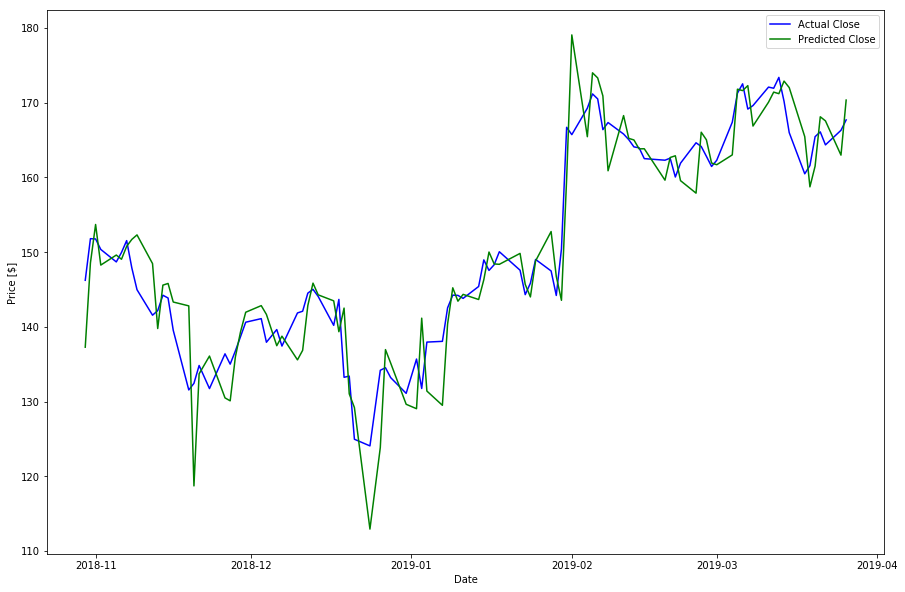

In [14]:
print('TestScore RMSE: %.2f' % (root_mse))

plt.figure(figsize=(15,10))
plt.plot(df_results_lstm_2[["Date"]], df_results_lstm_2[["Close"]], 'b-')
plt.plot(df_results_lstm_2[["Date"]], df_results_lstm_2[["Prediction"]], 'g-')
plt.xlabel('Date')
plt.ylabel('Price [$]')
plt.legend(["Actual Close", "Predicted Close"])
plt.show()

Now RMSE is lower.
<br>
But still not much better and training time is too long to be able to optimize the network/running configuration.

## Changing course
After some time and progress I understood that I had a misconception about how LSTM works.
<br>
When training, we should traing on the whole training dataset, while every training sample includes the timeseries of the whole look_back window.
<br>
Then when predicting, the input data for prediction includes a timeseries as well.
<br>
This means that if give some arbitrary sample from the testing set to predict, the prediction will take into consideration the weights of the model and **also** the data from the look_book window of the days before that sample.
<br>
The misconception was that previously I thought that a prediction on an arbitrary sample from the testing set won't consider the X days before that sample, which are crucial for prediction.
<br><br>
To understand better LSTM - if we have f features and look_back window of size l, then a single sample would be a matrix of size (l,f).
<br>
While in regular ANN a single sampe would be just a 1-dimensional array of size f.
<br>
Therefore, a full input for training or prediction would be a 3-dimensional array of size (n,l,f) where n is the number of samples.

### New input-output for model
The previus model was trained in a wrong way and with bad configuration
<br>
Now I use the following method which is much simpler:
- Use the same network model as previously
- Split the data to training and testing sets
- Train using the training set, while the epochs are done inside the model and not externally
- Use a larger batch size in order to run faster
- Make the prediction on the testing set
- Plot the loss of the model
- The RMSE is calculated by the actual and predicted values of the testing set

In [4]:
import logging
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split


def predict_close_lstm(df, batch_size=1, look_back=4, epochs=100, verbose=2):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)
    
    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

    # Take only the training columns
    df_train = df_train.loc[:, ["Close"]]
    df_test = df_test.loc[:, ["Close"]]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Train the model using the training set
    model = create_model(batch_size, look_back=look_back)
    model_res = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }



def fit_to_batch_size(dataset, batch_size):
    # Remove from the dataset the last samples that don't fit the batch size
    unfit_samples_num = dataset.shape[0] % batch_size
    if unfit_samples_num > 0:
        dataset = dataset[:-unfit_samples_num]

    return dataset


def create_model(batch_size, look_back, regularization_factor=0, dropout=False, custom_optimizer=False):
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(regularization_factor)))

    if custom_optimizer:
        learning_rate = 0.005
        optimzer = optimizers.RMSprop(lr=learning_rate)
    else:
        optimzer = 'adam'

    model.compile(loss='mean_squared_error', optimizer=optimzer)

    return model


def create_lstm_dataset(dataset, look_back=1):
    data_x, data_y = [], []

    # Go through all samples, shift by 1 on every iteration
    # Look upfront to next look_back samples
    for i in range(len(dataset) - look_back - 1):
        # Get next look_back samples
        look_back_window = dataset[i:(i + look_back), 0]
        data_x.append(look_back_window)

        # Get the look_back+1 sample for the "y"
        data_y.append(dataset[i + look_back, 0])

    # Reshape input to be [samples, time steps, features]
    data_x = np.array(data_x)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))

    return data_x, np.array(data_y)


def plot_prediction_results(data):
    # Plot the loss in every epoch during training
    plt.figure(figsize=(15,10))
    plt.plot(data["model_loss"])
    plt.title("Loss during training")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train"])
    plt.show()

    # Plot the actual values vs predicted values in the testing set
    plt.figure(figsize=(15,10))
    plt.plot(data["test_y"])
    plt.plot(data["test_y_predicted"])
    plt.title("Testing set - Predicted vs Actual")
    plt.xlabel("Day")
    plt.ylabel("Close Price")
    plt.legend(["Real", "Prediction"])
    plt.show()


def run_single_configuration(batch_size=5, look_back=3, epochs=60, plot_results=True):
    # Read data
    df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Run prediction
    res = predict_close_lstm(df, batch_size=batch_size, look_back=look_back, epochs=epochs)
    print("Test RMSE: %.2f" % (res["test_rmse"]))

    # Plot results
    if plot_results:
        plot_prediction_results(res)

    return res

In [22]:
res = run_single_configuration(batch_size=5, look_back=3, epochs=60, plot_results=False)

Epoch 1/60
 - 3s - loss: 0.0018
Epoch 2/60
 - 1s - loss: 0.0159
Epoch 3/60
 - 1s - loss: 0.0111
Epoch 4/60
 - 1s - loss: 0.0079
Epoch 5/60
 - 1s - loss: 0.0065
Epoch 6/60
 - 1s - loss: 0.0057
Epoch 7/60
 - 1s - loss: 0.0051
Epoch 8/60
 - 1s - loss: 0.0045
Epoch 9/60
 - 1s - loss: 0.0040
Epoch 10/60
 - 1s - loss: 0.0035
Epoch 11/60
 - 1s - loss: 0.0030
Epoch 12/60
 - 1s - loss: 0.0025
Epoch 13/60
 - 1s - loss: 0.0021
Epoch 14/60
 - 1s - loss: 0.0017
Epoch 15/60
 - 1s - loss: 0.0015
Epoch 16/60
 - 1s - loss: 0.0013
Epoch 17/60
 - 1s - loss: 0.0011
Epoch 18/60
 - 1s - loss: 9.4672e-04
Epoch 19/60
 - 1s - loss: 8.3961e-04
Epoch 20/60
 - 1s - loss: 7.2843e-04
Epoch 21/60
 - 1s - loss: 6.0821e-04
Epoch 22/60
 - 1s - loss: 5.3441e-04
Epoch 23/60
 - 1s - loss: 5.2361e-04
Epoch 24/60
 - 1s - loss: 5.0915e-04
Epoch 25/60
 - 1s - loss: 5.1006e-04
Epoch 26/60
 - 1s - loss: 7.0989e-04
Epoch 27/60
 - 1s - loss: 5.7440e-04
Epoch 28/60
 - 1s - loss: 5.6144e-04
Epoch 29/60
 - 1s - loss: 7.5787e-04
Epoc

In [23]:
print("Test RMSE: %.2f" % (res["test_rmse"]))

Test RMSE: 4.72


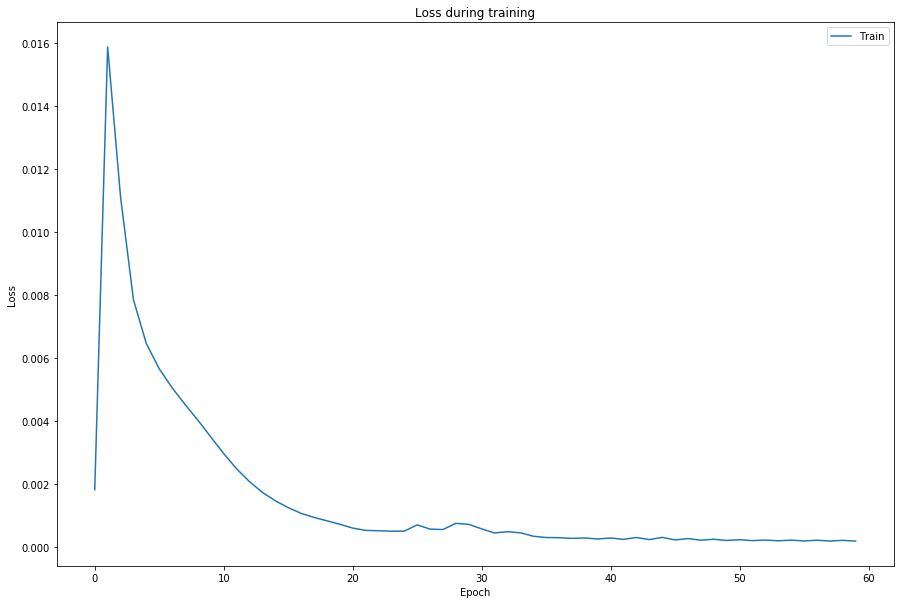

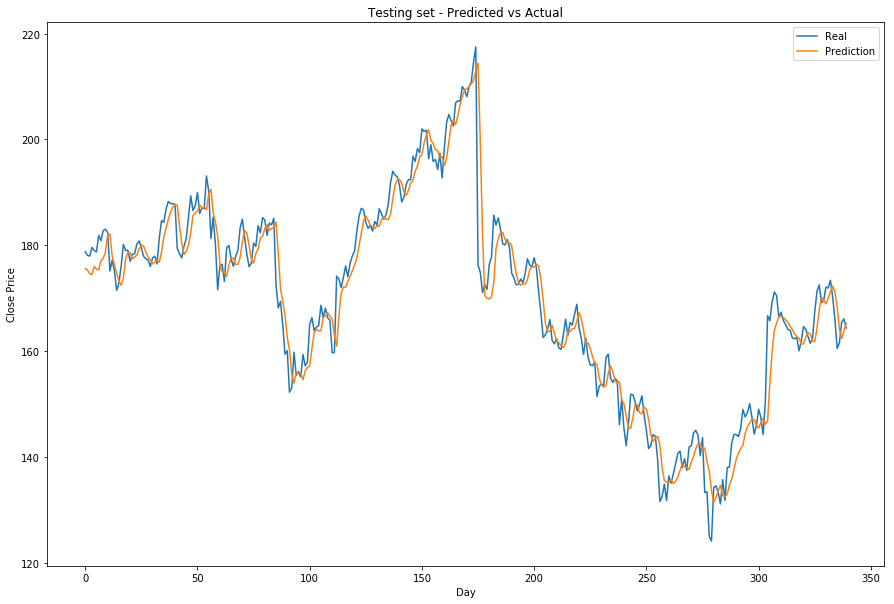

In [24]:
plot_prediction_results(res)

### Analyzing results
The RMSE of this testing set (20% of the samples, 345 last days) is **4.72**
<br>
The RMSE of linear regression on the last 345 days is **5.26** (calculated on the "Proposal" notebook)
<br>
Now we got much better results and the running time was small!
<br>
It means that we can try easily different batch sizes and look backs to find the optimal configuration


### Parameter optimization

In [5]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [61]:
def run_multiple_configurations(batch_sizes = [20, 10, 5, 4, 3, 2, 1], look_backs = [20, 10, 7, 5, 4, 3, 2, 1]):
    # Read data
    df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


    # Create a DF to hold the results of RMSE for all combinations
    df_rmse = pd.DataFrame(columns=["{} look_back".format(i) for i in look_backs])

    # Calc RMSE for all windows sizes X number of poly features
    for batch_size in batch_sizes:
        rmse_look_back = []
        for look_back in look_backs:
            logger.info("Training batch_size {}, look_back {}".format(batch_size, look_back))

            # Run prediction
            res = predict_close_lstm(df, batch_size=batch_size, look_back=look_back, epochs=100, verbose=0)
            rmse_look_back.append(res["test_rmse"])
            logger.debug("RMSE for batch size %s, look back %s: %s", batch_size, look_back, res["test_rmse"])
        df_rmse.loc["batch_size {}".format(batch_size)] = rmse_look_back

    # Plot on map
    plt.figure(figsize=(5, 5))
    sns.heatmap(df_rmse, cmap="YlGnBu", annot=True, fmt='.2f')
    plt.show()

    return df_rmse

2019-05-07 00:31:27,550 - INFO - Training batch_size 20, look_back 20
2019-05-07 00:33:06,531 - INFO - Training batch_size 20, look_back 10
2019-05-07 00:34:08,679 - INFO - Training batch_size 20, look_back 7
2019-05-07 00:34:59,571 - INFO - Training batch_size 20, look_back 5
2019-05-07 00:35:42,506 - INFO - Training batch_size 20, look_back 4
2019-05-07 00:36:26,709 - INFO - Training batch_size 20, look_back 3
2019-05-07 00:37:09,369 - INFO - Training batch_size 20, look_back 2
2019-05-07 00:37:47,940 - INFO - Training batch_size 20, look_back 1
2019-05-07 00:38:24,636 - INFO - Training batch_size 10, look_back 20
2019-05-07 00:42:04,525 - INFO - Training batch_size 10, look_back 10
2019-05-07 00:44:20,795 - INFO - Training batch_size 10, look_back 7
2019-05-07 00:46:14,001 - INFO - Training batch_size 10, look_back 5
2019-05-07 00:47:35,443 - INFO - Training batch_size 10, look_back 4
2019-05-07 00:48:49,370 - INFO - Training batch_size 10, look_back 3
2019-05-07 00:49:57,800 - INFO

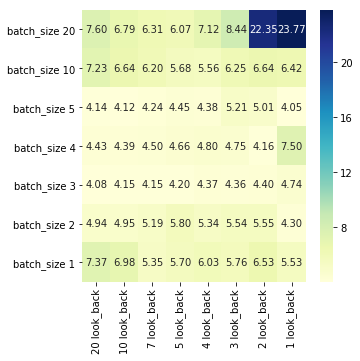

In [62]:
df_rmse = run_multiple_configurations()

### Parameter optimization results
#### Determinism of model
I found out that when running the mode with the same configuration at 2 different times, the results are not the same. i.e. the RMSE is different.
<br>
After spending a lot of time on determining what happens, and moving the "np.random.seed(7)" to be initialized at the beginning of every run, I could find the symptoms but not the root cause.
<br>
The batch size, look back and especially number of epochs affect the change rate between runs (with the same configuration).
<br>
For example:
- When running with batch_size=4, look_back=3, epochs=60, in 2 distinct runs, we got the following RMSEs: 4.977, 4.98
- But when running with batch_size=20, look_back=3, epochs=140, in 2 distinct runs, we got the following RMSEs: 6.968, 6.68 - much larger diff
- Sometimes the diff can be even larger.
<br>

Another interesting thing is that the seed has a large influence on the model:
- with seed(7) - got the following RMSE: 4.56
- with seed(1) - got the following RMSE: 4.97

#### Speed of running and choosing the parameter
First of all we can see that the running time heavily depends on the look back and the batch size.
<br>
Larger batch size = running faster
<br>
Smaller look back = running faster
<br>
With batch_size=1, look_back=20 - it was running 19 minutes
<br>
With batch_size=20, look_back=1 - it was running 19 seconds
<br>
The best RMSE is 4.01, achieved with batch_size=5, look_back=1
<br>
For next operations, I'll choose a configuration that has pretty good RMSE and a medium look_back / batch size.
<br><br>
**Chosen configuration:** batch_size=4, look_back=10, epochs=100 (RMSE 4.39)

### Cross validation and plotting loss values
When running manually different kinds of configurations I observed that the loss value of the model may jump a lot during the epochs.
<br>
Furthermore, the final loss value doesn't influence much the RMSE.
<br>
I could expect low loss value --> low RMSE, but I know that overfitting will result in low loss value and high RMSE (high error on the testing set.
<br>
It turns out that Keras has a built-in feature for getting the loss value of a cross validation set during epochs.
<br>
Let's split the testing set to testing set / cross validation set.
<br>
Then use the cross validation set for calculating the loss during training.
<br>
And use the testing set for prediction (as before)


In [6]:
def predict_close_lstm(df, batch_size=1, look_back=4, epochs=100, verbose=2):
    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

    # Take only the training columns
    df_train = df_train.loc[:, ["Close"]]
    df_test = df_test.loc[:, ["Close"]]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Split testing set to testing set and cross validation set (50%-50%)
    test_x, cv_x = np.split(test_x, 2)
    test_y, cv_y = np.split(test_y, 2)

    # Fit again after splitting
    test_x = fit_to_batch_size(test_x, batch_size)
    cv_x = fit_to_batch_size(cv_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)
    cv_y = fit_to_batch_size(cv_y, batch_size)
    logger.debug("Training size: %s. Cross validation size: %s. Testing size: %s.", train_x.shape[0], cv_x.shape[0], test_x.shape[0])

    # Train the model using the training set
    model = create_model(batch_size, look_back=look_back)
    model_res = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False, validation_data=(cv_x, cv_y))

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "cv_loss": model_res.history['val_loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }

def run_single_configuration(batch_size=5, look_back=3, epochs=60, plot_results=True, verbose=2):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)

    # Read data
    df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Run prediction
    res = predict_close_lstm(df, batch_size=batch_size, look_back=look_back, epochs=epochs, verbose=verbose)
    print("Test RMSE: %.2f" % (res["test_rmse"]))

    # Plot results
    if plot_results:
        plot_prediction_results(res)

    return res

def plot_prediction_results(data, plot_predicted_vs_actual=True, plot_loss=True):
    # Plot the loss in every epoch during training
    if plot_loss:
        plt.figure(figsize=(15,10))
        plt.plot(data["model_loss"])
        plt.plot(data["cv_loss"])
        plt.title("Loss during training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Cross validation"])
        plt.show()

    # Plot the actual values vs predicted values in the testing set
    if plot_predicted_vs_actual:
        plt.figure(figsize=(15, 10))
        plt.plot(data["test_y"])
        plt.plot(data["test_y_predicted"])
        plt.title("Testing set - Predicted vs Actual")
        plt.xlabel("Day")
        plt.ylabel("Close Price")
        plt.legend(["Real", "Prediction"])
        plt.show()

In [52]:
res = run_single_configuration(batch_size=4, look_back=10, epochs=60, plot_results=False)

Train on 1364 samples, validate on 164 samples
Epoch 1/60
 - 24s - loss: 0.0014 - val_loss: 0.2009
Epoch 2/60
 - 4s - loss: 0.0071 - val_loss: 0.1063
Epoch 3/60
 - 4s - loss: 0.0020 - val_loss: 0.0468
Epoch 4/60
 - 4s - loss: 8.3462e-04 - val_loss: 0.0291
Epoch 5/60
 - 4s - loss: 6.4882e-04 - val_loss: 0.0242
Epoch 6/60
 - 4s - loss: 6.1592e-04 - val_loss: 0.0216
Epoch 7/60
 - 4s - loss: 6.0469e-04 - val_loss: 0.0199
Epoch 8/60
 - 4s - loss: 5.9925e-04 - val_loss: 0.0186
Epoch 9/60
 - 4s - loss: 5.9559e-04 - val_loss: 0.0175
Epoch 10/60
 - 4s - loss: 5.9207e-04 - val_loss: 0.0167
Epoch 11/60
 - 4s - loss: 5.8760e-04 - val_loss: 0.0159
Epoch 12/60
 - 4s - loss: 5.8154e-04 - val_loss: 0.0151
Epoch 13/60
 - 4s - loss: 5.7369e-04 - val_loss: 0.0145
Epoch 14/60
 - 4s - loss: 5.6426e-04 - val_loss: 0.0138
Epoch 15/60
 - 4s - loss: 5.5360e-04 - val_loss: 0.0132
Epoch 16/60
 - 4s - loss: 5.4214e-04 - val_loss: 0.0126
Epoch 17/60
 - 4s - loss: 5.3023e-04 - val_loss: 0.0120
Epoch 18/60
 - 4s - l

In [54]:
print("Test RMSE: %.2f" % (res["test_rmse"]))

Test RMSE: 3.77


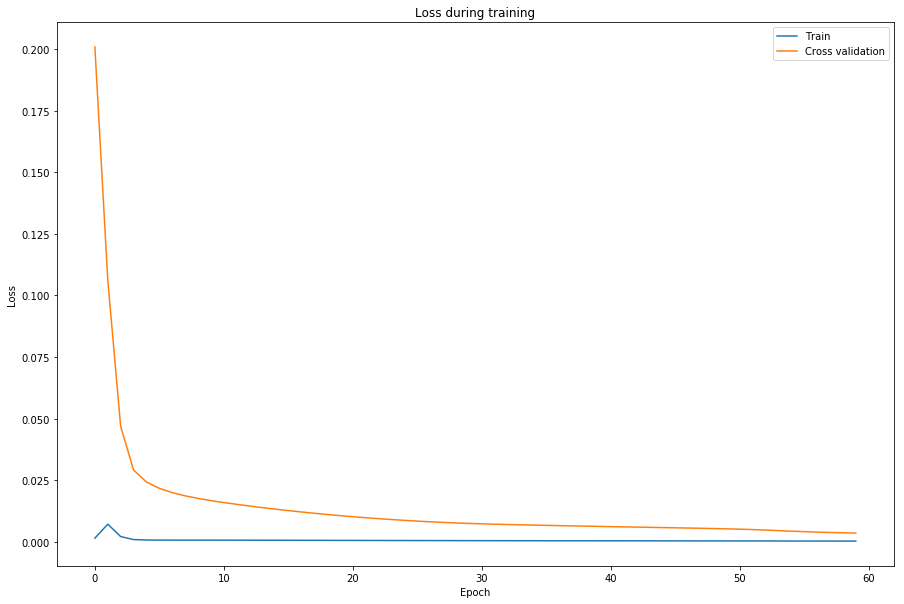

In [53]:
plot_prediction_results(res, plot_predicted_vs_actual=False)

Plot the loss of only the last 30 epochs in order to change the scale of the graph and zomm in:


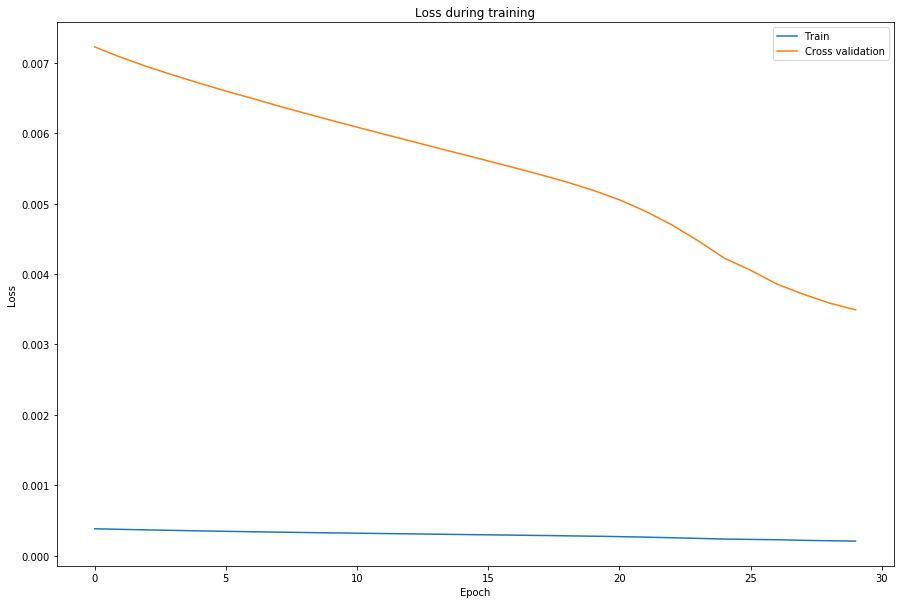

In [39]:
plt.figure(figsize=(15,10))
plt.plot(res["model_loss"][30:])
plt.plot(res["cv_loss"][30:])
plt.title("Loss during training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Cross validation"])
plt.show()

### Intermmediate conlusions
- The RMSE value with the cross validation input is now different, since the testing set is pretty small, and that we split it to test and cv, it got even smaller.
- Another reason for the difference in the RMSE is that the CV set helps the model change the weights in every epoch while validating the gradient error
- The model loss is getting smaller from epoch to epoch
- The cross validation loss is also getting smaller
- The gap between the testing and cv loss is getting smaller, which means that the model is able to generalize and not overfitting.

Let's try to run with 120 epochs and see if it's getting even better:

In [42]:
res = run_single_configuration(batch_size=4, look_back=10, epochs=120, plot_results=False, verbose=0)

Test RMSE: 3.70


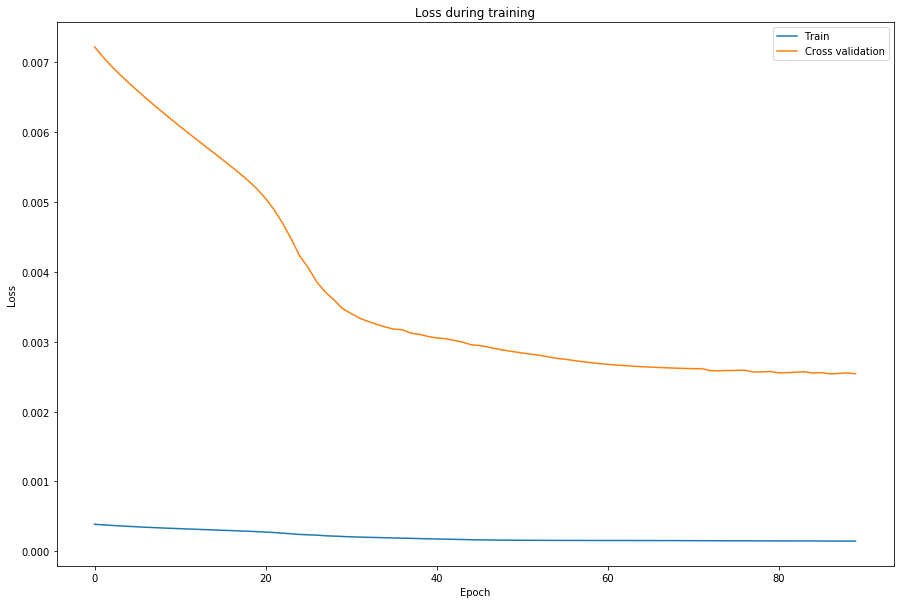

In [43]:
plt.figure(figsize=(15,10))
plt.plot(res["model_loss"][30:])
plt.plot(res["cv_loss"][30:])
plt.title("Loss during training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Cross validation"])
plt.show()

**Conlusion** - After the 90th epoch, the loss of CV is not getting better, so training with more than 90 epochs is useless.
<br>
I'll later try different methods to optimize the results.

### Using more features
Let's use all the available features when training (and also when predicting).
<br>
The following features will be used: Close, Open, High, Low, Volume.

In [66]:
def predict_close_lstm(df, batch_size=1, look_back=4, epochs=100, verbose=2, use_all_features=False):
    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

    # Take only the training columns
    feature_columns = ["Close"]
    if use_all_features:
        feature_columns += ["Open", "High", "Low", "Volume"]
    df_train = df_train.loc[:, feature_columns]
    df_test = df_test.loc[:, feature_columns]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Split testing set to testing set and cross validation set (50%-50%)
    test_x, cv_x = np.split(test_x, 2)
    test_y, cv_y = np.split(test_y, 2)

    # Fit again after splitting
    test_x = fit_to_batch_size(test_x, batch_size)
    cv_x = fit_to_batch_size(cv_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)
    cv_y = fit_to_batch_size(cv_y, batch_size)
    logger.debug("Training size: %s. Cross validation size: %s. Testing size: %s.", train_x.shape[0], cv_x.shape[0], test_x.shape[0])

    # Train the model using the training set
    model = create_model(batch_size, look_back=look_back, features_num=train_x.shape[2])
    model_res = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False, validation_data=(cv_x, cv_y))

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "cv_loss": model_res.history['val_loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }

def run_single_configuration(batch_size=5, look_back=3, epochs=60, plot_results=True, verbose=2, use_all_features=False):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)

    # Read data
    df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Run prediction
    res = predict_close_lstm(df, batch_size=batch_size, look_back=look_back, epochs=epochs, verbose=verbose, use_all_features=use_all_features)
    print("Test RMSE: %.2f" % (res["test_rmse"]))

    # Plot results
    if plot_results:
        plot_prediction_results(res)

    return res

def create_model(batch_size, look_back, regularization_factor=0, dropout=False, custom_optimizer=False, features_num=1):
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features_num), stateful=True, return_sequences=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features_num), stateful=True))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(regularization_factor)))

    if custom_optimizer:
        learning_rate = 0.005
        optimzer = optimizers.RMSprop(lr=learning_rate)
    else:
        optimzer = 'adam'

    model.compile(loss='mean_squared_error', optimizer=optimzer)

    return model


def create_lstm_dataset(dataset, look_back=1, y_column_index=0):
    data_x, data_y = [], []

    # Go through all samples, shift by 1 on every iteration
    # Look upfront to next look_back samples
    for i in range(len(dataset) - look_back - 1):
        # Get next look_back samples
        look_back_window = dataset[i:(i + look_back), 0:dataset.shape[1]]
        data_x.append(look_back_window)

        # Get the look_back+1 sample for the "y"
        data_y.append(dataset[i + look_back, y_column_index])

    # Reshape input to be [samples, time steps, features]
    data_x = np.array(data_x)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], data_x.shape[2]))

    return data_x, np.array(data_y)

Test RMSE: 4.12


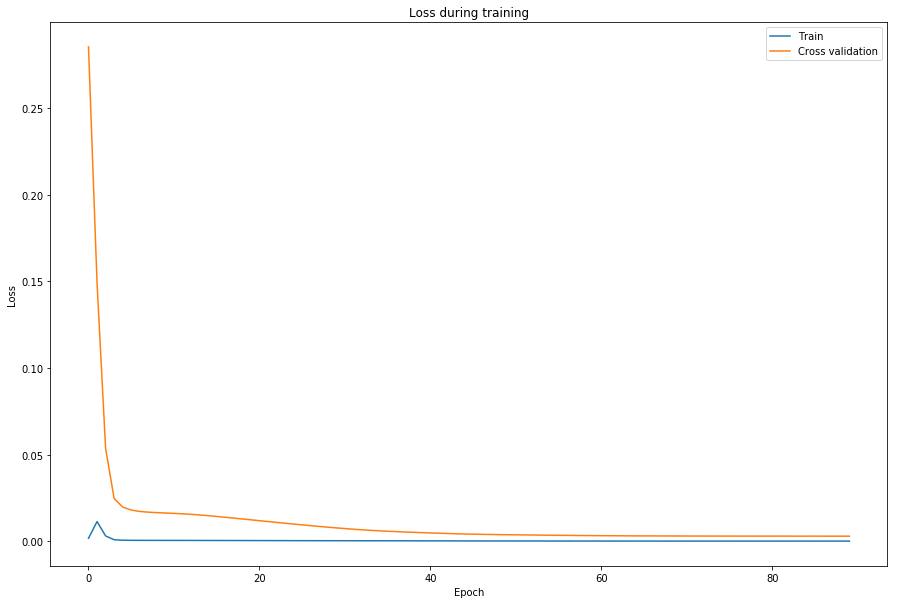

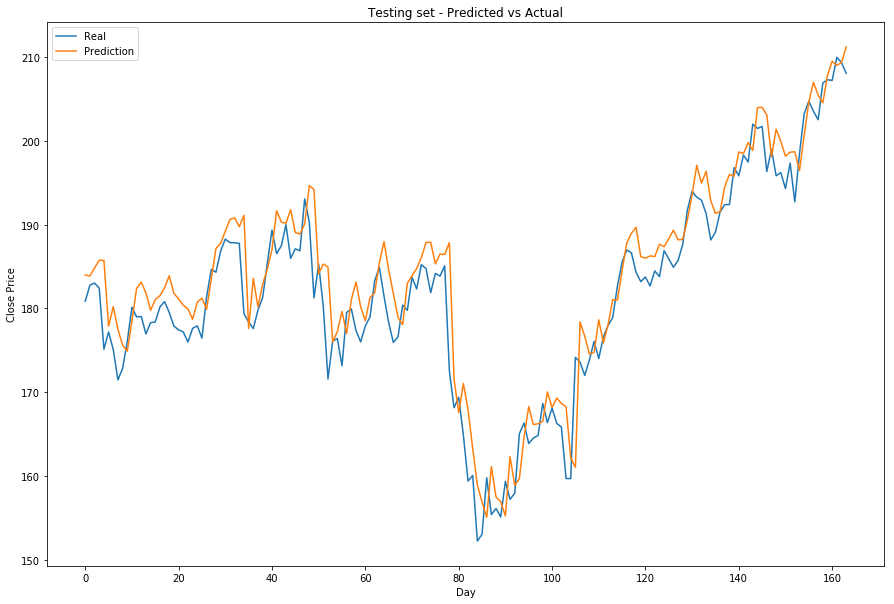

In [46]:
res = run_single_configuration(batch_size=4, look_back=10, epochs=90, plot_results=True, verbose=0, use_all_features=True)

**Conclusions**
<br>
RMSE with all features is 4.12 while RMSE with the "Close" feature only is 3.78
<br>
My conclusion is that the Close feature actuall influence the Close price of next day, while other features don't and just add noise to the model.

### Trying other network layer configurations of the model

The code was changed to be fully configurable externally by passing configs:

In [7]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def predict_close_lstm(df, configs):
    # Unpack configs
    look_back = configs["model"]["look_back"]
    batch_size = configs["model"]["batch_size"]

    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=configs["general"]["train_size"], test_size=(1 - configs["general"]["train_size"]),
                                         shuffle=False)

    # Take only the training columns
    feature_columns = ["Close"]
    if configs["general"]["use_all_features"]:
        feature_columns += ["Open", "High", "Low", "Volume"]
    df_train = df_train.loc[:, feature_columns]
    df_test = df_test.loc[:, feature_columns]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Split testing set to testing set and cross validation set (50%-50%)
    test_x, cv_x = np.split(test_x, 2)
    test_y, cv_y = np.split(test_y, 2)

    # Fit again after splitting
    test_x = fit_to_batch_size(test_x, batch_size)
    cv_x = fit_to_batch_size(cv_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)
    cv_y = fit_to_batch_size(cv_y, batch_size)
    logger.debug("Training size: %s. Cross validation size: %s. Testing size: %s.", train_x.shape[0], cv_x.shape[0], test_x.shape[0])

    # Train the model using the training set
    model = create_model(configs, features_num=train_x.shape[2])
    model_res = model.fit(train_x, train_y, epochs=configs["model"]["epochs"], batch_size=batch_size, verbose=configs["general"]["verbose"],
                          shuffle=False, validation_data=(cv_x, cv_y))

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "cv_loss": model_res.history['val_loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }


def fit_to_batch_size(dataset, batch_size):
    # Remove from the dataset the last samples that don't fit the batch size
    unfit_samples_num = dataset.shape[0] % batch_size
    if unfit_samples_num > 0:
        dataset = dataset[:-unfit_samples_num]

    return dataset


def create_model(configs, features_num=1):
    # Unpack configs
    batch_size = configs["model"]["batch_size"]
    look_back = configs["model"]["look_back"]
    dropout_val = configs["model"]["network"]["dropout_val"]
    regularization_factor = configs["model"]["network"]["regularization_factor"]
    lstm_neurons = configs["model"]["network"]["lstm_neurons"]

    model = Sequential()

    # Add LSTM layers
    for i, lstm_neurons_layer in enumerate(lstm_neurons):
        # We need to return sequences only for all layers except the last one
        return_sequences = (i < len(lstm_neurons) - 1)

        # Add the layer
        model.add(LSTM(lstm_neurons_layer, batch_input_shape=(batch_size, look_back, features_num), stateful=True, return_sequences=return_sequences,
                       kernel_regularizer=regularizers.l2(regularization_factor)))

        # Add dropout for the later
        if dropout_val > 0:
            model.add(Dropout(dropout_val))

    # Add output layer
    model.add(Dense(1, kernel_regularizer=regularizers.l2(regularization_factor)))

    # Optional optimizer to control the learning rate
    if configs["model"]["network"]["custom_optimizer"]:
        learning_rate = 0.005
        optimzer = optimizers.RMSprop(lr=learning_rate)
    else:
        optimzer = 'adam'

    model.compile(loss='mean_squared_error', optimizer=optimzer)

    return model


def create_lstm_dataset(dataset, look_back=1, y_column_index=0):
    data_x, data_y = [], []

    # Go through all samples, shift by 1 on every iteration
    # Look upfront to next look_back samples
    for i in range(len(dataset) - look_back - 1):
        # Get next look_back samples
        look_back_window = dataset[i:(i + look_back), 0:dataset.shape[1]]
        data_x.append(look_back_window)

        # Get the look_back+1 sample for the "y"
        data_y.append(dataset[i + look_back, y_column_index])

    # Reshape input to be [samples, time steps, features]
    data_x = np.array(data_x)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], data_x.shape[2]))

    return data_x, np.array(data_y)


def plot_prediction_results(data, plot_predicted_vs_actual=True, plot_loss=True, plot_loss_last=False):
    # Plot the loss in every epoch during training
    if plot_loss:
        plt.figure(figsize=(10, 5))
        plt.plot(data["model_loss"])
        plt.plot(data["cv_loss"])
        plt.title("Loss during training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Cross validation"])
        plt.show()

    if plot_loss_last:
        plt.figure(figsize=(10, 5))
        plt.plot(data["model_loss"][30:])
        plt.plot(data["cv_loss"][30:])
        plt.title("Loss during training (last epochs)")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Cross validation"])
        plt.show()

    # Plot the actual values vs predicted values in the testing set
    if plot_predicted_vs_actual:
        plt.figure(figsize=(10, 5))
        plt.plot(data["test_y"])
        plt.plot(data["test_y_predicted"])
        plt.title("Testing set - Predicted vs Actual")
        plt.xlabel("Day")
        plt.ylabel("Close Price")
        plt.legend(["Real", "Prediction"])
        plt.show()


def run_single_configuration(configs):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)

    # Read data
    df = pd.read_csv('~/code/dscience/stocks/data/facebook.csv', engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Run prediction
    res = predict_close_lstm(df, configs)
    print("Test RMSE: %.2f" % (res["test_rmse"]))

    # Plot results
    if configs["general"]["plot_results"]:
        plot_prediction_results(res)

    return res

### Running original configuration again

In [26]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 70,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_original = run_single_configuration(configs)

Test RMSE: 3.80


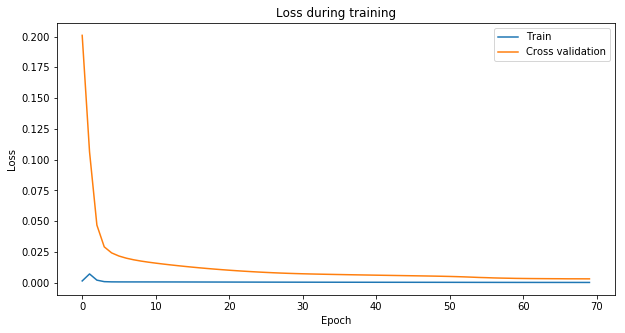

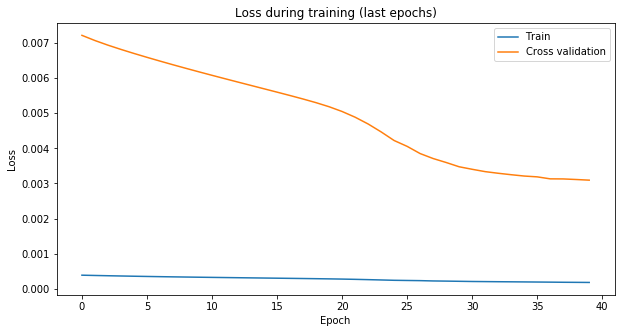

In [27]:
plot_prediction_results(res_original, plot_predicted_vs_actual=False, plot_loss_last=True)

### Increasing neurons (20 in each LSTM layer instead of 4)

In [62]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 70,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [20, 20]
        }
    }
}
res_20_neurons = run_single_configuration(configs)

Instructions for updating:
Colocations handled automatically by placer.


2019-05-11 14:01:52,947 - WARNING - From /home/edi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-11 14:01:53,260 - WARNING - From /home/edi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Test RMSE: 3.49


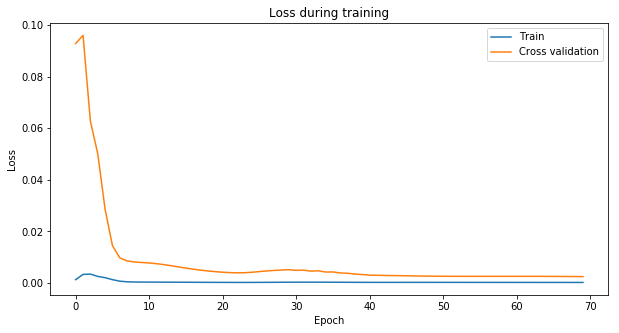

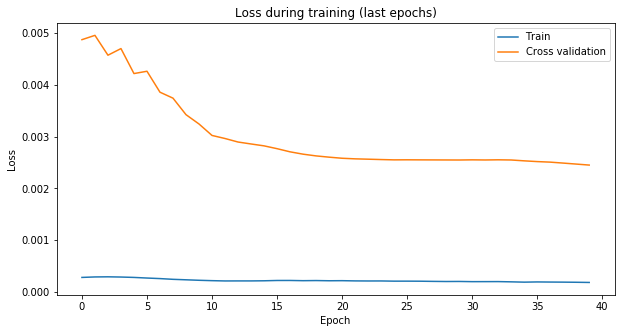

In [29]:
plot_prediction_results(res_20_neurons, plot_predicted_vs_actual=False, plot_loss_last=True)

#### Some insights:
- RMSE is now 3.42 while when we had 4 neurons in each layer, it was 3.8
- The gap between train and cv loss is getting smaller, but still fails to get to minimum.

Let's try a network with more neurons:

### Increasing neurons even more (70 in each LSTM layer)

In [32]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [70, 70]
        }
    }
}
res_70_neurons = run_single_configuration(configs)

Test RMSE: 4.05


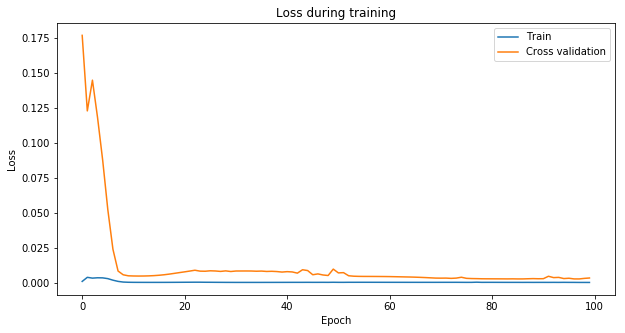

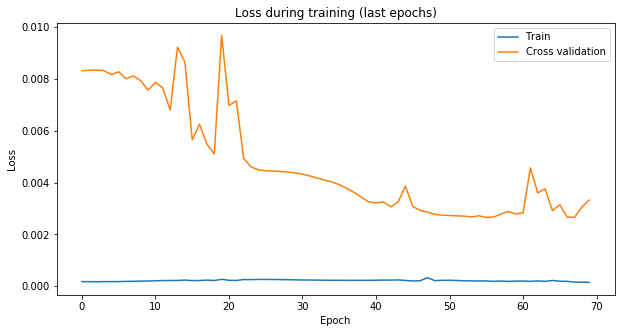

In [33]:
plot_prediction_results(res_70_neurons, plot_predicted_vs_actual=False, plot_loss_last=True)

### 70 neurons + dropout

In [34]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0.4,
            "lstm_neurons": [70, 70]
        }
    }
}
res_70_neurons_with_dropout = run_single_configuration(configs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-05-06 21:41:57,355 - WARNING - From /home/edi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Test RMSE: 5.92


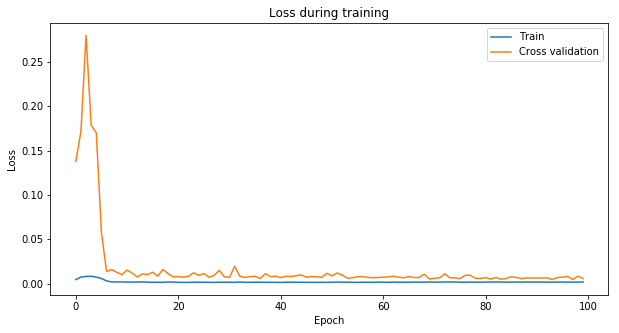

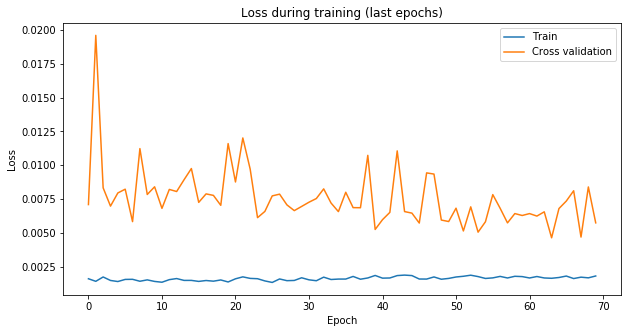

In [35]:
plot_prediction_results(res_70_neurons_with_dropout, plot_predicted_vs_actual=False, plot_loss_last=True)

### 4 neurons + dropout

In [37]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0.4,
            "lstm_neurons": [4, 4]
        }
    }
}
res_4_neurons_with_dropout = run_single_configuration(configs)

Test RMSE: 8.06


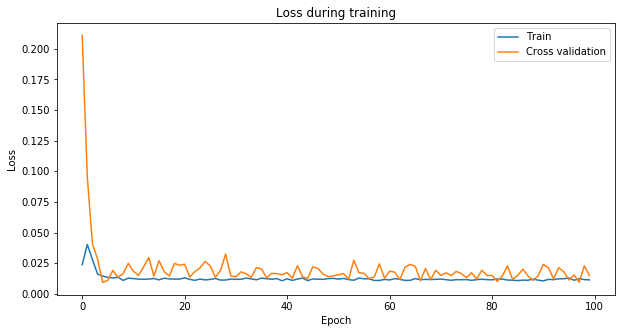

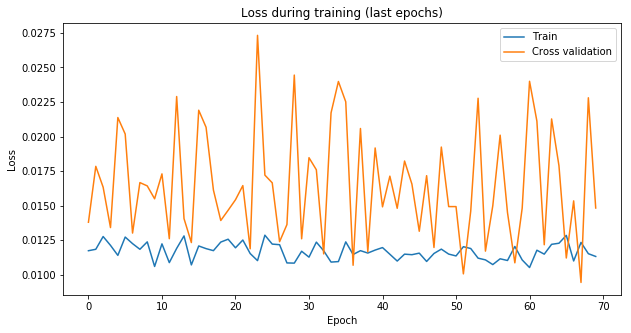

In [41]:
plot_prediction_results(res_4_neurons_with_dropout, plot_predicted_vs_actual=False, plot_loss_last=True)

### 4 neurons + regularization factor 0.9

In [39]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0.9,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_4_neurons_reg_09 = run_single_configuration(configs)

Test RMSE: 14.02


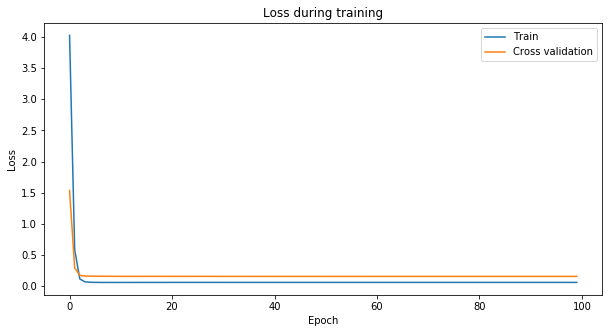

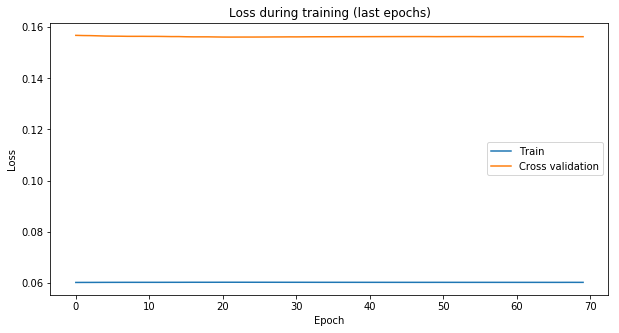

In [44]:
plot_prediction_results(res_4_neurons_reg_09, plot_predicted_vs_actual=False, plot_loss_last=True)

### 4 neurons + regularization factor 0.3

In [42]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0.3,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_4_neurons_reg_03 = run_single_configuration(configs)

Test RMSE: 12.77


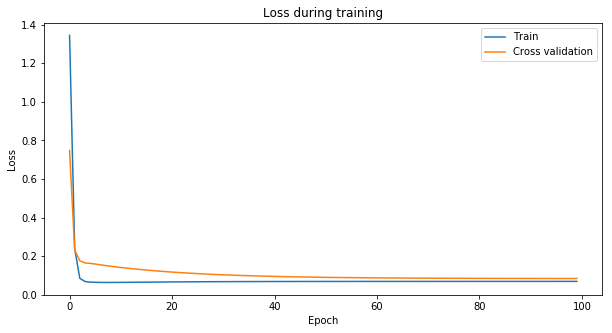

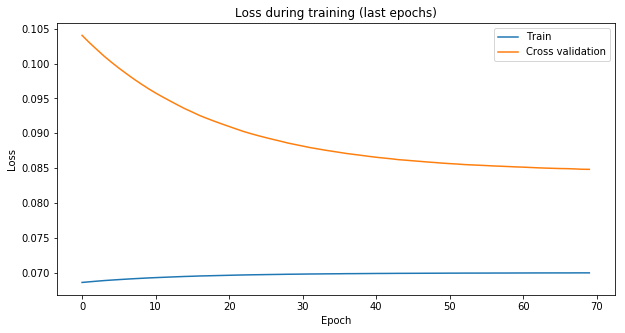

In [45]:
plot_prediction_results(res_4_neurons_reg_03, plot_predicted_vs_actual=False, plot_loss_last=True)

### Different dataset splitting (more for CV) + regulatization 0.3

Split to:
- Train - 60%
- CV - 20%
- Test - 20%
This the model will have a larger cross validation set to compare and update weights.
<br>
Also, the testing set will include 345 samples, so it will be easy to compare the RMSE.

In [46]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.6
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0.3,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_regul_03_split_20 = run_single_configuration(configs)

Test RMSE: 44.65


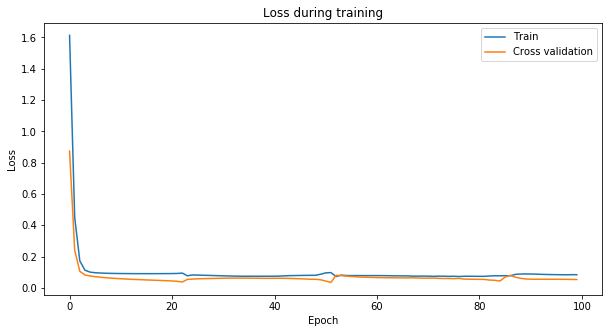

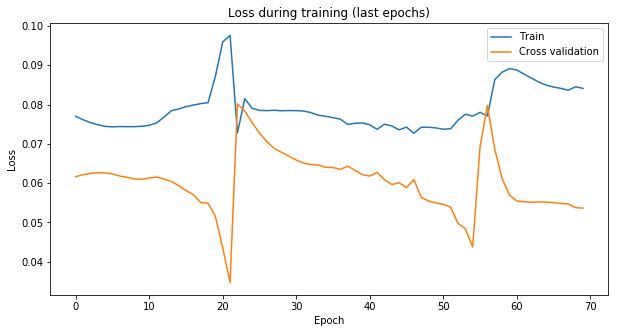

In [47]:
plot_prediction_results(res_regul_03_split_20, plot_predicted_vs_actual=False, plot_loss_last=True)

### Different dataset splitting (no regularization)

In [54]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.6
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 150,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_split_20 = run_single_configuration(configs)

Test RMSE: 4.18


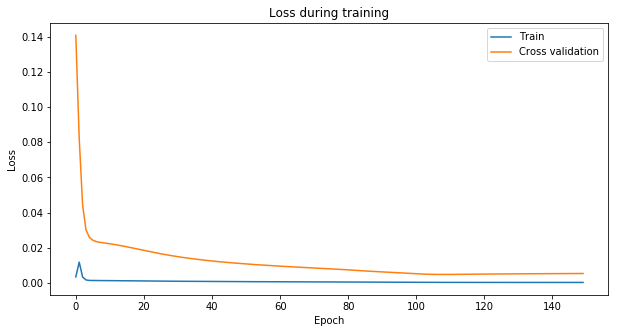

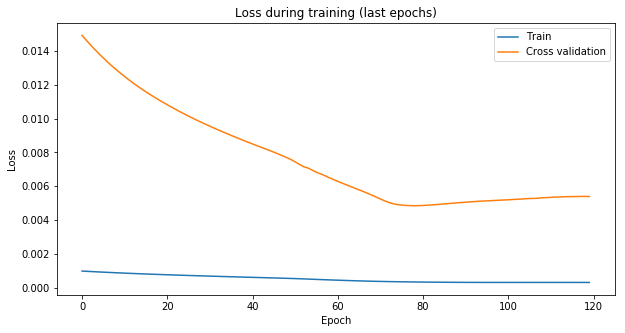

In [55]:
plot_prediction_results(res_split_20, plot_predicted_vs_actual=False, plot_loss_last=True)

### Different dataset splitting + regularization 0.3 + 20 neurons

In [52]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.6
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 100,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0.3,
            "dropout_val": 0,
            "lstm_neurons": [20, 20]
        }
    }
}
res_split_20_neurons_20_reg_03 = run_single_configuration(configs)

Test RMSE: 66.33


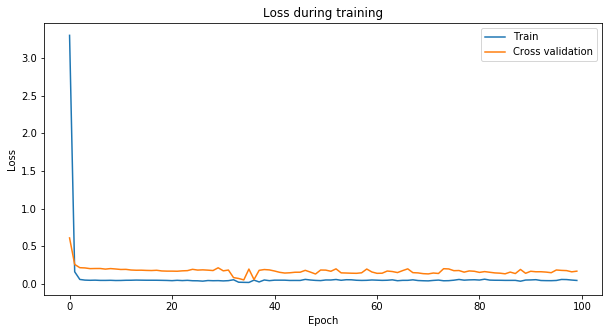

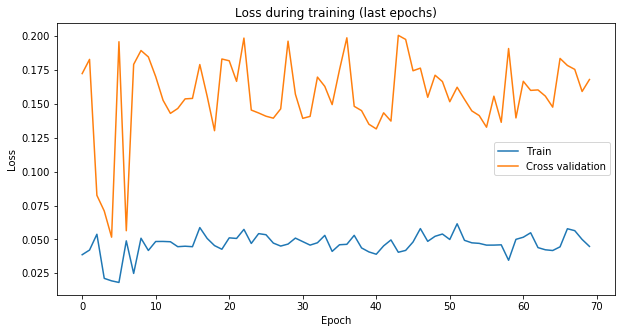

In [53]:
plot_prediction_results(res_split_20_neurons_20_reg_03, plot_predicted_vs_actual=False, plot_loss_last=True)

## Comparing to linear regression

In [8]:
def predict_close_linear_regression(file_path, num_of_days, window_size=4):
    # Load file
    df = pd.read_csv(file_path, engine='python')
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'] ,format='%Y-%m-%d')
    
    # Remove unused columns
    df.drop(columns="Adj Close", inplace=True)
    
    cur_day = len(df) - numebr_of_days

    model = LinearRegression()

    actuals = []
    predictions = []

    # Go through all requested days and make a new training for every day
    for i in range(cur_day, cur_day + num_of_days):
        # For each day, train a new model using Close values of previous days.
        # Number of previous days is defined by "window_size"
        samples_start = i - window_size
        samples_end = i - 1

        # The X is the features vector and it includes just an index because we're using time series data
        # X - index
        # Y - actual Close values
        X = np.array(range(samples_start, samples_end + 1))
        Y = np.array(df["Close"][samples_start:samples_end + 1])
        X = X.reshape(window_size, 1)
        Y = Y.reshape(window_size, 1)

        # Train the model
        model.fit(X, Y)

        # Predict current day according to the linear regression trained model
        cur_day_prediction = model.predict(np.array([i]).reshape(1, 1))[0][0]
        predictions.append(cur_day_prediction)

        cur_day_actual = df.iloc[i]["Close"]
        actuals.append(cur_day_actual)

    # Build a DataFrame that includes the actual and predicted results on the given data set
    df_results = df.iloc[cur_day:cur_day + num_of_days]
    df_results = df_results.drop(columns=["Open", "High", "Low", "Volume"])
    cols_pred = pd.Series(predictions, index=range(cur_day, cur_day + num_of_days))
    df_results["Prediction"] = pd.Series(cols_pred)
    
    root_mse = math.sqrt(mean_squared_error(actuals, predictions))
        
    return actuals, predictions, df_results, root_mse

In [9]:
numebr_of_days = 172
filename="data/facebook.csv"
res_actuals_linear, res_predicted_linear, df_results_linear, rmse_linear = predict_close_linear_regression(filename, numebr_of_days)
print("RMSE of last {} days: {}".format(numebr_of_days, rmse_linear))

RMSE of last 172 days: 5.6991532740249875


### Fixing test set (swapping test <> cv)
After some investigation of mismatches in comparison of results below, I found out that when splitting the testing set in LSTM to 2, the first bulk was the test and the second one was the cv.
<br>
It means that in order to easily compare to linear regression, we need to swap the test/cv sets in LSTM, so that we'll compare the last X values.

In [10]:
def predict_close_lstm(df, configs):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)

    # Unpack configs
    look_back = configs["model"]["look_back"]
    batch_size = configs["model"]["batch_size"]

    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=configs["general"]["train_size"], test_size=(1 - configs["general"]["train_size"]),
                                         shuffle=False)

    # Take only the training columns
    feature_columns = ["Close"]
    if configs["general"]["use_all_features"]:
        feature_columns += ["Open", "High", "Low", "Volume"]
    df_train = df_train.loc[:, feature_columns]
    df_test = df_test.loc[:, feature_columns]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Split testing set to testing set and cross validation set (50%-50%)
    cv_x, test_x  = np.split(test_x, 2)
    cv_y, test_y = np.split(test_y, 2)

    # Fit again after splitting
    test_x = fit_to_batch_size(test_x, batch_size)
    cv_x = fit_to_batch_size(cv_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)
    cv_y = fit_to_batch_size(cv_y, batch_size)
    logger.debug("Training size: %s. Cross validation size: %s. Testing size: %s.", train_x.shape[0], cv_x.shape[0], test_x.shape[0])

    # Train the model using the training set
    model = create_model(configs, features_num=train_x.shape[2])
    model_res = model.fit(train_x, train_y, epochs=configs["model"]["epochs"], batch_size=batch_size, verbose=configs["general"]["verbose"],
                          shuffle=False, validation_data=(cv_x, cv_y))

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "cv_loss": model_res.history['val_loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }

Run again the best config in order to get the fixed testing set:

In [129]:
configs = {
    "general": {
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.8
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 70,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [20, 20]
        }
    }
}
res_20_neurons = run_single_configuration(configs)

Test RMSE: 4.61


Let's verify that tests sets of LSTM and linear regression are equal:

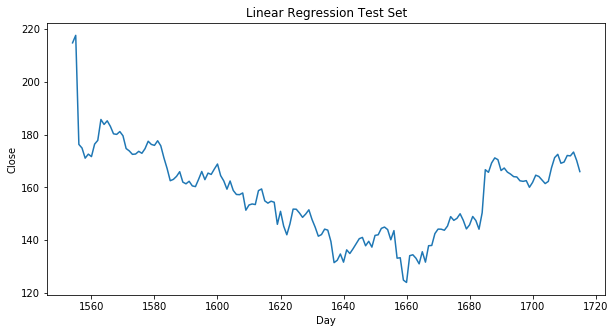

In [147]:
df_results_linear_cut = df_results_linear[-174:-10]
plt.figure(figsize=(10, 5))
plt.plot(df_results_linear_cut["Close"])
plt.title("Linear Regression Test Set")
plt.ylabel("Close")
plt.xlabel("Day")
plt.show()

In [160]:
df_res_20_neurons = pd.DataFrame({'Close': res_20_neurons['test_y'], 'Prediction': res_20_neurons['test_y_predicted']})

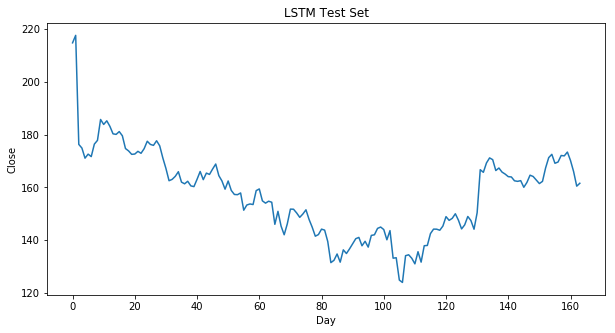

In [161]:
plt.figure(figsize=(10, 5))
plt.plot(df_res_20_neurons[-164:]["Close"])
plt.title("LSTM Test Set")
plt.ylabel("Close")
plt.xlabel("Day")
plt.show()

The test sets are the same when taking:
- LSTM - last 164 values 
- Linear regression - values [-174:-10] (last 164 values, shifted 10 values to the left because of the look_back window of LSTM

### Simulate buying stocks

We've seen that for the given testing set (last 172 samples), linear regression gives RMSE 5.69, while LSTM gives RMSE 3.42 (batch_size=4, look_back=10, epochs=70, neurons: [20,20]).
Let's try to make another simulation of buying stocks

Using the simulate_buy function from previous notebook:

In [11]:
def simulate_buy(df, stock_units, sim_type):
    random.seed(datetime.datetime.now())
    bought = False
    buy_price = 0

    stats = {
        "transactions_count": 0,
        "total_bought": 0,
        "total_revenue": 0,
        "period_days": len(df)
    }

    for i in range(len(df)):
        tomorrow_close_prediction = df.iloc[i]["Prediction"]
        today_close = df.iloc[i]["Close"]

        # Sell what we bought yesterday (if we bought any)
        if bought:
            sell_price = today_close * stock_units
            revenue = (sell_price - buy_price)
            buy_price = 0
            stats["total_revenue"] += revenue
            bought = False

        # Buy next day
        if sim_type == "prediction":
            should_buy = today_close < tomorrow_close_prediction
        else:
            should_buy = random.randint(1, 2) == 1

        if should_buy:
            # Buy
            bought = True
            buy_price = today_close * stock_units
            stats["total_bought"] += buy_price
            stats["transactions_count"] += 1

    return stats

Simulate buying in last 172 days by taking benefit of the linear regression predictions:

In [149]:
# Simulate buying stocks daily by relying on prediction
stats_prediction_linear = simulate_buy(df_results_linear_cut, 5, sim_type="prediction")

In [150]:
stats_prediction_linear

{'transactions_count': 80,
 'total_bought': 62829.54988000002,
 'total_revenue': -74.8000300000001,
 'period_days': 162}

The revenue is negative.
<br>
Verify that it's not worse that buying randomly:

In [151]:
# Simulate buying stocks daily randomly (try 100 times)
total_revenues = []
for i in range(100):
    stats_randomly = simulate_buy(df_results_linear_cut, 5, sim_type="random")
    total_revenues.append(stats_randomly["total_revenue"])
mean_simulate_random = np.mean(total_revenues)

In [152]:
mean_simulate_random

-125.00451170000001

It's not worser, but pretty close to buying with random decision.
<br>
Maybe we have a problem with the simulation itself.
<br>
Simulate buying by using the "predictions" of actual tomorrows' values.
<br>
If the simulation is good, we must have a positive (and high) revenue

In [153]:
# Simulate buying with actual tomorrow's value "predictions"
df_actual_predictions = df_results_linear_cut.copy()
for index, row in df_actual_predictions.iterrows():
    try:
        df_actual_predictions.loc[index, 'Prediction'] = df_actual_predictions.loc[index + 1]['Close']
    except:
        pass
stats_actual_prediction = simulate_buy(df_actual_predictions, 5, sim_type="prediction")
print(stats_actual_prediction)

{'transactions_count': 78, 'total_bought': 60377.24961500001, 'total_revenue': 968.3000200000001, 'period_days': 162}


Results are OK.
<br>
I would expect a higher revenue, but maybe there weren't much opportunities to sell in high and buy low.
<br>
Let's plot the Close values:

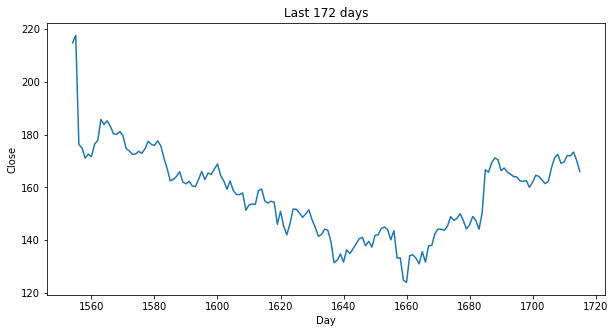

In [154]:
plt.figure(figsize=(10, 5))
plt.plot(df_actual_predictions["Close"])
plt.title("Last 172 days")
plt.ylabel("Close")
plt.xlabel("Day")
plt.show()

The graph is indeed pretty volatile and there is a large decline in share prices.
<br>
It's difficult to perform in such a market using our simulation.
<br>
Let's change the simulation a little bit to decide whether to buy or not according to the diff between the current and tomorrow's preidiction values:

In [12]:
def simulate_buy(df, stock_units, sim_type, buy_decision_threshold=0):
    random.seed(datetime.datetime.now())
    bought = False
    buy_price = 0

    stats = {
        "transactions_count": 0,
        "total_bought": 0,
        "total_revenue": 0,
        "yield": 0,
        "period_days": len(df)
    }

    for i in range(len(df)):
        tomorrow_close_prediction = df.iloc[i]["Prediction"]
        today_close = df.iloc[i]["Close"]

        # Sell what we bought yesterday (if we bought any)
        if bought:
            sell_price = today_close * stock_units
            revenue = (sell_price - buy_price)
            buy_price = 0
            stats["total_revenue"] += revenue
            bought = False

        # Buy next day
        if sim_type == "prediction":
            should_buy = tomorrow_close_prediction - today_close > buy_decision_threshold
        else:
            should_buy = random.randint(1, 2) == 1

        if should_buy:
            # Buy
            bought = True
            buy_price = today_close * stock_units
            stats["total_bought"] += buy_price
            stats["transactions_count"] += 1

    stats["yield"] = stats["total_revenue"] / stats["total_bought"] * 100

    return stats

In [157]:
stats_actual_prediction = simulate_buy(df_actual_predictions, 5, sim_type="prediction", buy_decision_threshold=2.0)
print(stats_actual_prediction)

{'transactions_count': 33, 'total_bought': 25333.799894999996, 'total_revenue': 716.29998, 'yield': 2.8274478482060346, 'period_days': 162}


It did help in this case.
<br>
When we've set the diff threshold for decision to buy, to $2, the yield increased from 1.5% to 2.8%

Let's try to buy using linear regression predictions:

In [172]:
stats_actual_prediction = simulate_buy(df_results_linear_cut, 5, sim_type="prediction", buy_decision_threshold=3.0)
print(stats_actual_prediction)

{'transactions_count': 38, 'total_bought': 29725.999914999997, 'total_revenue': -76.39998499999956, 'yield': -0.2570140120381534, 'period_days': 162}


A negative yield of -0.25%.

Let's use the LSTM predictions (20 neurons in each layer, no dropout, no regularization, batch_size=4, look_back=10, epochs=70):

In [171]:
stats_lstm_prediction = simulate_buy(df_res_20_neurons, 5, sim_type="prediction", buy_decision_threshold=3.0)
print(stats_lstm_prediction)

{'transactions_count': 29, 'total_bought': 21942.74986499999, 'total_revenue': 69.05007000000046, 'yield': 0.3146828470671285, 'period_days': 164}


### Conclusions
LSTM performs much better than linear regression!
<br>
From losing money in a declining market by using linear regression, we turned to earning money using LSTM.

## Trying other stocks

Following previous plan, let's try to check some stocks with lower volatility. Facebook stock is pretty volatile - it has a Beta value of 1.2 for the last 3Y Monthly, while Pepsi stock has a Beta value of 0.5
<br>
Maybe our model will work better with stable stocks and with stocks that have more data, so that training will be better.
<br>
The objective is to "earn" more money that it was possible with the facebook stock.

In [15]:
def run_single_configuration(configs):
    # Read data
    df = pd.read_csv(configs['general']['file'], engine='python', skipfooter=3)
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Run prediction
    res = predict_close_lstm(df, configs)
    print("Test RMSE: %.2f" % (res["test_rmse"]))

    # Plot results
    if configs["general"]["plot_results"]:
        plot_prediction_results(res)

    return res

In [19]:
configs = {
    "general": {
        "file": "data/PEP.csv",
        "plot_results": False,
        "verbose": 0,
        "use_all_features": False,
        "train_size": 0.7
    },
    "model": {
        "batch_size": 4,
        "look_back": 10,
        "epochs": 70,
        "network": {
            "custom_optimizer": False,
            "regularization_factor": 0,
            "dropout_val": 0,
            "lstm_neurons": [4, 4]
        }
    }
}
res_4_neurons_pepsi = run_single_configuration(configs)

Test RMSE: 8.26


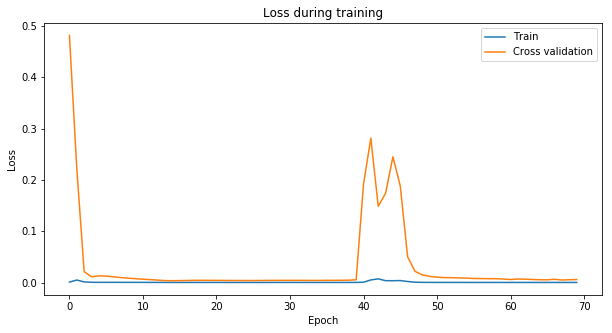

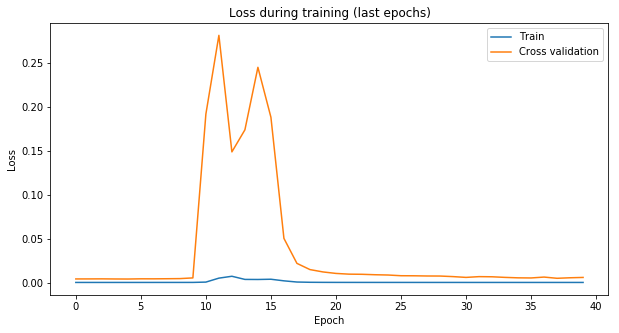

In [20]:
plot_prediction_results(res_4_neurons_pepsi, plot_predicted_vs_actual=False, plot_loss_last=True)

In [30]:
df_res_20_neurons = pd.DataFrame({'Close': res_4_neurons_pepsi['test_y'], 'Prediction': res_4_neurons_pepsi['test_y_predicted']})
stats_lstm_prediction = simulate_buy(df_res_20_neurons, 5, sim_type="prediction", buy_decision_threshold=2.0)
print(stats_lstm_prediction)

{'transactions_count': 1755, 'total_bought': 847961.6001950008, 'total_revenue': 325.2000050000002, 'yield': 0.03835079382429769, 'period_days': 1768}


High RMSE for LSTM (even though there is a lot of data), gives 0.03% yields. Still, pretty bad.

Let's try linear regression:

In [31]:
numebr_of_days = 1776
filename="data/PEP.csv"
res_actuals_linear_pepsi, res_predicted_linear_pepsi, df_results_linear_pepsi, rmse_linear_pepsi = predict_close_linear_regression(filename, numebr_of_days)
print("RMSE of last {} days: {}".format(numebr_of_days, rmse_linear_pepsi))

RMSE of last 1776 days: 1.0632168999378107


In [46]:
# Simulate buying stocks daily by relying on prediction
stats_prediction_linear_pep = simulate_buy(df_results_linear_pepsi, 5, sim_type="prediction")
print(stats_prediction_linear_pep)

{'transactions_count': 881, 'total_bought': 426028.59988999995, 'total_revenue': 330.3001050000013, 'yield': 0.07753003086771272, 'period_days': 1776}


Also low yields (0.07%) even though the RMSE is pretty low.

Let's try simulation with actual values as "predicted" values:

In [42]:
# Simulate buying with actual tomorrow's value "predictions"
df_actual_predictions_pep = df_results_linear_pepsi.copy()
for index, row in df_actual_predictions_pep.iterrows():
    try:
        df_actual_predictions_pep.loc[index, 'Prediction'] = df_actual_predictions_pep.loc[index + 1]['Close']
    except:
        pass
stats_actual_prediction_pep = simulate_buy(df_actual_predictions_pep, 5, sim_type="prediction", buy_decision_threshold=4.0)
print(stats_actual_prediction_pep)

{'transactions_count': 2, 'total_bought': 1150.85003, 'total_revenue': 48.64997500000004, 'yield': 4.22730796644286, 'period_days': 1776}


Still not that high. 4% of yield is something that can be earned in solidic products like bonds ("agah").
<br>
Obviously the simulation is not that good, and it may be possible to improve the buying decision algorithm.
<br>
Anyway, let's focus on the LSTM model - and try to improve it.

## Learning with hyper parameters

In [50]:
def predict_close_lstm(df, configs):
    # If we don't have a fixed seed, every time that I train the model, it predicts different results.
    # Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
    np.random.seed(7)

    # Unpack configs
    look_back = configs["model"]["look_back"]
    batch_size = configs["model"]["batch_size"]

    # Split to 2 dataframes: train and test
    df_train, df_test = train_test_split(df, train_size=configs["general"]["train_size"], test_size=(1 - configs["general"]["train_size"]),
                                         shuffle=False)

    # Take only the training columns
    feature_columns = ["Close"]
    if configs["general"]["use_all_features"]:
        feature_columns += ["Open", "High", "Low", "Volume"]
    df_train = df_train.loc[:, feature_columns]
    df_test = df_test.loc[:, feature_columns]

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features = scaler.fit_transform(df_train.values)
    test_features = scaler.fit_transform(df_test.values)

    # Reshape into X=t and Y=t+1
    train_x, train_y = create_lstm_dataset(train_features, look_back=look_back)
    test_x, test_y = create_lstm_dataset(test_features, look_back=look_back)

    # Fit training and testing samples to batch size
    train_x = fit_to_batch_size(train_x, batch_size)
    train_y = fit_to_batch_size(train_y, batch_size)
    test_x = fit_to_batch_size(test_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)

    # Split testing set to testing set and cross validation set (50%-50%)
    cv_x, test_x = np.array_split(test_x, 2)
    cv_y, test_y = np.array_split(test_y, 2)

    # Fit again after splitting
    test_x = fit_to_batch_size(test_x, batch_size)
    cv_x = fit_to_batch_size(cv_x, batch_size)
    test_y = fit_to_batch_size(test_y, batch_size)
    cv_y = fit_to_batch_size(cv_y, batch_size)
    logger.debug("Training size: %s. Cross validation size: %s. Testing size: %s.", train_x.shape[0], cv_x.shape[0], test_x.shape[0])

    # Train the model using the training set
    model = create_model(configs, features_num=train_x.shape[2])
    model_res = model.fit(train_x, train_y, epochs=configs["model"]["epochs"], batch_size=batch_size, verbose=configs["general"]["verbose"],
                          shuffle=False, validation_data=(cv_x, cv_y))

    # Predict the testing set
    test_y_predicted = model.predict(test_x, batch_size=batch_size)

    # Denormalize
    # We can't use scaler.inverse_transform() because it was previously used to fit the whole dataframe
    # which is 2-dimensional, while test_y and test_y_pred are 1-dimensional.
    # The solution is to manually calculate the original values by using the min/max variables
    # of the scaler (which were saved from last fit operation)
    # (I verified correctness of this method by inversing the test_x values and comparing to original)
    test_y = (test_y * scaler.data_range_[0]) + scaler.data_min_[0]
    # Reshape the predicted array to be flat
    test_y_predicted = test_y_predicted.flatten()
    test_y_predicted = (test_y_predicted * scaler.data_range_[0]) + scaler.data_min_[0]

    # Calc error on the testing set
    test_rmse = math.sqrt(mean_squared_error(test_y, test_y_predicted))

    return {
        "model_loss": model_res.history['loss'],
        "cv_loss": model_res.history['val_loss'],
        "test_y": test_y,
        "test_y_predicted": test_y_predicted,
        "test_rmse": test_rmse
    }

In [51]:
def optimize_parameters():
    search_space = {
        'model_batch_size': hp.choice('model_batch_size', [10, 5, 3]),
        'model_look_back': hp.choice('model_look_back', [10, 7, 4, 2]),
        'network_lstm_neurons_l1': hp.choice('network_lstm_neurons_l1', [4, 20, 70, 100]),
        'network_lstm_neurons_l2': hp.choice('network_lstm_neurons_l2', [4, 20, 70, 100]),
        'network_dropout_val': hp.uniform('network_dropout_val', 0, 1),
        'network_reg_factor': hp.uniform('network_reg_factor', 0, 0.7)
    }

    def run_hyperopt_single(params):
        configs = {
            "general": {
                "file": "data/facebook.csv",
                "plot_results": False,
                "verbose": 2,
                "use_all_features": False,
                "train_size": 0.7
            },
            "model": {
                "batch_size": params['model_batch_size'],
                "look_back": params['model_look_back'],
                "epochs": 70,
                "network": {
                    "custom_optimizer": False,
                    "regularization_factor": params['network_reg_factor'],
                    "dropout_val": params['network_dropout_val'],
                    "lstm_neurons": [params['network_lstm_neurons_l1'], params['network_lstm_neurons_l2']]
                }
            }
        }
        logger.info("Running current config: %s", configs)

        res_single_run = run_single_configuration(configs)
        cv_loss = np.amin(res_single_run['cv_loss'])

        logger.info("Loss for config %s: %s", params, cv_loss)

        return {
            'status': hyperopt.STATUS_OK,
            'loss': cv_loss,
            'configs': configs,
            'run_result': res_single_run
        }

    trials = hyperopt.Trials()
    res_hyperopt = hyperopt.fmin(run_hyperopt_single, space=search_space, algo=hyperopt.tpe.suggest, trials=trials, max_evals=1000)
    logger.info("Best result:\nConfigs: %s\nTest RMSE: %s", trials.best_trial['result']['configs'],
                trials.best_trial['result']['run_result']['test_rmse'])

### Increasing training speed by running on a GPU enabled machine

There are many parameters to optimize, actually there are 3x4x4x4x(0,1)x(0,0.7) which in my point of view needs at least 1000 evaluations (max_evals).
<br>
When started running it, the following info is printed:
```
  0%|          | 1/1000 [05:36<54:15:27, 195.52s/it, best loss: 0.03825392738162052]
```
About 2.5 days of running will be needed on my laptop.
<br>
It's too much time for running, and I also need to use the laptop daily.
<br>
My laptop is i7 with 8 cores, but doesn't have GPU. So I came up with an idea to run the network on a machine on AWS.
<br>

#### Installing the machine
Turns out that AWS already have an [image](https://aws.amazon.com/marketplace/pp/B07CNFWMPC) with preinstalled anaconda and tensorflow.
<br>
After inspecting some AWS instance types, the chosen instance type was [p3.xlarge](https://aws.amazon.com/ec2/instance-types/p3/).
<br>
This instance includes 4vcpus and 1 [NVIDIA Tesla K80 GPU](https://www.nvidia.com/en-gb/data-center/tesla-k80/).
<br>
It costs $0.9/h on US East (N.Virginia) region.
<br>
So I started this instance, found out that anaconda and the whole environment is already installed, but GPU was not available.

#### Dealing with GPU
To make the GPU available I started installing `CUDA` and `nvidia drivers` and `tensforflow-gpu`.
<br>
But it was complicated and took much time and things didn't work.
<br>
Then I found out that AWS have a whole set of images for Machine Learning with all GPU drivers pre-installed. It's called [DLAMI](https://docs.aws.amazon.com/dlami/latest/devguide/gs.html) (deep learning ami).
<br>
So I launched [this](https://aws.amazon.com/marketplace/pp/B077GCH38C?ref=cns_srchrow) specific image that includes Anaconda + GPU drivers + CUDA + tensorflow-gpu
<br>
And then used [this](https://docs.aws.amazon.com/dlami/latest/devguide/tutorial-conda.html) tutorial that explains how to enable the `tensorflow_p36` conda environment to have GPU-enabled tensrflow pre-installed.

#### Validating that GPU is running
Now that GPU is enabled, I could verify it using this method that prints the available GPUs on the machine:
```python
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
```
I started running the `optimize_parameters` function that I previously tried running on my laptop but still the training was very slow and it looks like there isn't any improvement.
<br>
That has led me to an assumption that Keras uses CPU instead of GPU.
<br><br>
But every article or documentation on the internet says that Tensforflow uses GPU by default if GPU is available and tensorflow-gpu is installed.
<br>
Then I tried a couple of methods to force usage of GPU:
<br>
Try 1 - Force GPU:
```python
config = tensorflow.ConfigProto(device_count={'GPU': 1, 'CPU': 1}, intra_op_parallelism_threads=2, inter_op_parallelism_threads=2, allow_soft_placement=False)
keras.backend.set_session(tensorflow.Session(config=config))
```
Try 2 - Export env var `CUDA_VISIBLE_DEVICES=0`
<br><br>
Try 3 - Run something explicitly on GPU (it succeeded):
```python
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print(sess.run(c))
```
None of these methods made the model train faster!
<br>
Then I found that all of this is not enough because Keras has a special layer for LSTM that has improvements for running on CUDA.
<br>
It's called `CuDNNLSTM` and all is needed is just importing and using `CuDNNLSTM` instead of `LSTM`.
<br>
After doing that, it looked like something has changed and the training runs a little bit faster.
<br>
But still not that kind of improvement that I was expecting.

#### Utilizing the GPU
After reading some more about how GPU improves model training, I started testing different kinds of configurations.
<br>
The `nvidia-smi` command was in use to watch the GPU utilization (and temperature).
This is an example for the output:
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   76C    P0   130W / 149W |  11022MiB / 11441MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0     18703      C   python3                                    11009MiB |
+-----------------------------------------------------------------------------+

```

#### Some observations
- On small networks or small batch size, the GPU is not working on 100% but may be only half.
- When having a larger batch size, the model was trained **x10** times faster
- The model was trained x10 times faster also when having deeper networks with many neurons (for example 200x200x200x200)

#### Conclusions
- In our case where we have a small dataset, increasing batch size won't give good results, so GPU won't help in this case.
- A good way to run hyperopt would be running it on an AWS instance without GPU. For example on c5.xlarge which has 4vcpus and 8GB RAM. It costs only \\$0.17/h, so running it for 2.5 days for training hyperopt will cost just \\$10. 

## Next:
- Run hyperopt on AWS machine
- Check learning curve as Andrew NG explains